# Topic Analysis

In this notebook, we examine the clustered topics, inspect statistical tests on observed topic proportions (from `topic_regressions.R`), and examine the identity of authors across clusters.

The clusters are derived from `clustering.py`.


In [1]:
import random
import ast
import textwrap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from src.utils.helper_funcs import find_project_root, ensure_dir_exists
from src.utils.data_loader import load_data, unnest_columns
from src.viz.plot_config import *

# Apply Seaborn settings
sns.set(**seaborn_params)

# Apply Matplotlib settings
plt.rcParams.update(matplotlib_params)

# Set seed
random.seed(42)


# Set data path
PROJECT_ROOT = find_project_root()
CLUSTER_PATH = f"{PROJECT_ROOT}/results/clusters"
PLOT_PATH = f"{PROJECT_ROOT}/results/plots/cluster_plots"
ensure_dir_exists(PLOT_PATH)


# Load data
data_dict = load_data(PROJECT_ROOT, models=False, metadata=False)
# Unpack dictionary
for key, dataset in data_dict.items():
    # Unnest the survey columns for ease of analysis
    if key == "survey":
        nested_columns = ["location", "religion", "ethnicity"]
        dataset = unnest_columns(dataset, nested_columns)
        data_dict[key] = dataset
    # Inspect each dataset
    print(f"{key}: {dataset.shape}")
    display(dataset.head(2))
    print("\n")

survey: (1500, 48)


user_id  survey_only  num_completed_conversations  timing_duration_s  \
0   user0        False                            1                266   
1   user1        False                            6                632   

   timing_duration_mins   generated_datetime                      consent  \
0                  4.43  2023-11-22 15:48:46  Yes, I consent to take part   
1                 10.53  2023-11-22 15:56:10  Yes, I consent to take part   

                                   consent_age     lm_familiarity  \
0  I certify that I am 18 years of age or over  Somewhat familiar   
1  I certify that I am 18 years of age or over  Somewhat familiar   

  lm_indirect_use  ... location_reside_subregion location_reside_countryISO  \
0             Yes  ...          Northern America                        CAN   
1             Yes  ...          Northern America                        CAN   

  location_same_birth_reside_country location_special_region  \
0                                Yes        Northern America   
1                                Yes        Northern America   

  religion_self_described religion_categorised religion_simplified  \
0       prefer not to say    Prefer not to say   Prefer not to say   
1       prefer not to say    Prefer not to say   Prefer not to say   

  ethnicity_self_described ethnicity_categorised ethnicity_simplified  
0        prefer not to say     Prefer not to say    Prefer not to say  
1                caucasian                 White                White  

[2 rows x 48 columns]



conversations: (8011, 13)


conversation_id user_id  included_in_balanced_subset   generated_datetime  \
0              c0   user0                        False  2023-11-22 15:55:46   
1              c1   user1                         True  2023-11-22 16:07:49   

   timing_duration_s  timing_duration_mins conversation_type  \
0             401.07                  6.68          unguided   
1             642.97                 10.72          unguided   

                                      opening_prompt  conversation_turns  \
0   What can you do about the inequality  of wealth?                   5   
1  What can I do to start making extra money on t...                   2   

                                conversation_history  \
0  [{'turn': 0, 'role': 'user', 'content': 'What ...   
1  [{'turn': 0, 'role': 'user', 'content': 'What ...   

                              performance_attributes  \
0  {'values': None, 'fluency': 95, 'factuality': ...   
1  {'values': 50, 'fluency': 100, 'factuality': 1...   

                                   choice_attributes  \
0  {'values': None, 'fluency': 80, 'factuality': ...   
1  {'values': 50, 'fluency': 100, 'factuality': 1...   

                                       open_feedback  
0  Shorter blocks would  be nice.  but has  to ha...  
1  The first time I responded to the second quest...



utterances: (68371, 14)


utterance_id interaction_id conversation_id user_id  turn  within_turn_id  \
0          ut0           int0              c0   user0     0               0   
1          ut1           int0              c0   user0     0               1   

   included_in_balanced_subset conversation_type  \
0                        False          unguided   
1                        False          unguided   

                                        user_prompt  \
0  What can you do about the inequality  of wealth?   
1  What can you do about the inequality  of wealth?   

                                      model_response          model_name  \
0  Make it illegal for corporations to own a majo...  google/flan-t5-xxl   
1  As an AI language model, I cannot express pers...       command-light   

    model_provider  score  if_chosen  
0  huggingface_api     17      False  
1           cohere     92       True

### Model Names

In [2]:
model_name_table = pd.read_csv(
    f"{PROJECT_ROOT}/data/storage/mappings/model_mapping.csv"
)
# Turn into dictionary
model_name_mapping = dict(
    zip(model_name_table["long_name"], model_name_table["short_name"])
)
data_dict["utterances"]["model_name"] = data_dict["utterances"]["model_name"].map(
    lambda x: model_name_mapping[x] if x in model_name_mapping else x
)

model_code_mapping = dict(
    zip(model_name_table["short_name"], model_name_table["longcode"])
)

model_family_mapping = dict(
    zip(model_name_table["short_name"], model_name_table["model_family"])
)

## Load Clusters

In [3]:
# Load results where no preprocessing was done on the texts (=_original)
cluster_df = pd.read_csv(f"{CLUSTER_PATH}/opening_prompt_cluster_df_original.csv")
prompt_df = pd.read_csv(f"{CLUSTER_PATH}/opening_prompt_text_df_original.csv")

# Cluster df has the cluster metadata
display(cluster_df.head(2))

# Replace "" in cluster name
cluster_df["gpt_description"] = cluster_df["gpt_description"].map(
    lambda x: x.replace('"', "")
)

# Prompt df is organised at prompt-level (each row is prompt w/ cluster association)
display(prompt_df.head(2))

cluster_id  cluster_size           gpt_description  \
0          -1          2578                  Outliers   
1          19           816  "Managing Relationships"   

                                           top_words  \
0  ['think', 'people', 'hello', 'tell', 'like', '...   
1  ['family', 'relationship', 'important', 'think...   

                                           top_texts  
0  ['Hello', 'How do I become financially stable ...  
1  ['What advice would you give for a man betraye...

id                                               text  \
0  c0   What can you do about the inequality  of wealth?   
1  c1  What can I do to start making extra money on t...   

                                           orig_text  cluster_id  \
0   What can you do about the inequality  of wealth?          12   
1  What can I do to start making extra money on t...          18   

                                      umap_embedding  distance_to_centroid  \
0  [-0.005770721938461065, 4.160469055175781, 2.2...              0.183442   
1  [0.2052735984325409, 4.764413356781006, 2.3123...              0.906534   

         x2        y2  
0 -2.081124  4.850149  
1  0.288818  5.448434

In [4]:
# Merge the two dataframes
merge_df = prompt_df.merge(cluster_df, on="cluster_id", how="left")
# And also merge conversations by ID
merge_df = merge_df.merge(
    data_dict["conversations"], left_on="id", right_on="conversation_id", how="left"
)
# Now merge author data by user ID
df = merge_df.merge(data_dict["survey"], on="user_id", how="left")

# Inspect the merged dataframe
display(df.head(2))
print(df.shape)

id                                               text  \
0  c0   What can you do about the inequality  of wealth?   
1  c1  What can I do to start making extra money on t...   

                                           orig_text  cluster_id  \
0   What can you do about the inequality  of wealth?          12   
1  What can I do to start making extra money on t...          18   

                                      umap_embedding  distance_to_centroid  \
0  [-0.005770721938461065, 4.160469055175781, 2.2...              0.183442   
1  [0.2052735984325409, 4.764413356781006, 2.3123...              0.906534   

         x2        y2  cluster_size                        gpt_description  \
0 -2.081124  4.850149           135  Economic Policy and Income Inequality   
1  0.288818  5.448434           448                             Job Search   

   ... location_reside_subregion location_reside_countryISO  \
0  ...          Northern America                        CAN   
1  ...          Northern America                        CAN   

  location_same_birth_reside_country location_special_region  \
0                                Yes        Northern America   
1                                Yes        Northern America   

   religion_self_described religion_categorised  religion_simplified  \
0        prefer not to say    Prefer not to say    Prefer not to say   
1        prefer not to say    Prefer not to say    Prefer not to say   

   ethnicity_self_described ethnicity_categorised ethnicity_simplified  
0         prefer not to say     Prefer not to say    Prefer not to say  
1                 caucasian                 White                White  

[2 rows x 72 columns]

(8011, 72)


In [5]:
# Create version with no outliers
df_no_outliers = df[df["cluster_id"] != -1]
print(df_no_outliers.shape)

(5433, 72)


## Basic Summary Stats

In [6]:
# Summary stats
print(cluster_df.columns)
print(
    f"There are {cluster_df['cluster_id'].nunique()} clusters, including outlier cluster"
)

# Add pct to cluster_df
cluster_df["cluster_pct"] = (
    cluster_df["cluster_size"] / cluster_df["cluster_size"].sum()
)

# Display
cluster_df[["cluster_id", "gpt_description", "cluster_size", "cluster_pct"]]

Index(['cluster_id', 'cluster_size', 'gpt_description', 'top_words',
       'top_texts'],
      dtype='object')
There are 23 clusters, including outlier cluster


cluster_id                        gpt_description  cluster_size  \
0           -1                               Outliers          2578   
1           19                 Managing Relationships           816   
2           14    Popular Culture (Sports, Music, TV)           493   
3           18                             Job Search           448   
4            6              Religion and Spirituality           441   
5           17         Election and Political Parties           401   
6            8             Recipe and Cooking Queries           360   
7            3              Israel-Palestine Conflict           320   
8           13             Gender and LGBTQ+ Identity           286   
9           16                 Travel Recommendations           207   
10          11                         Climate Change           193   
11           7               Animal and Pet Inquiries           188   
12           1                Discussions on Abortion           158   
13          12  Economic Policy and Income Inequality           135   
14          20          Debating Immigration Policies           131   
15           0                 Greeting Introductions           131   
16          15      Exploring AI and Machine Learning           129   
17           4            Ethics of Death and Killing           119   
18           9             Health and Wellness Advice           111   
19          21         Discussions on Race and Racism            99   
20           5           Holiday Celebration Planning            98   
21          10                      Weather Inquiries            85   
22           2                 Global War Discussions            84   

    cluster_pct  
0      0.321808  
1      0.101860  
2      0.061540  
3      0.055923  
4      0.055049  
5      0.050056  
6      0.044938  
7      0.039945  
8      0.035701  
9      0.025839  
10     0.024092  
11     0.023468  
12     0.019723  
13     0.016852  
14     0.016353  
15     0.016353  
16     0.016103  
17     0.014855  
18     0.013856  
19     0.012358  
20     0.012233  
21     0.010610  
22     0.010486

### Examine Topic Distribution Overall

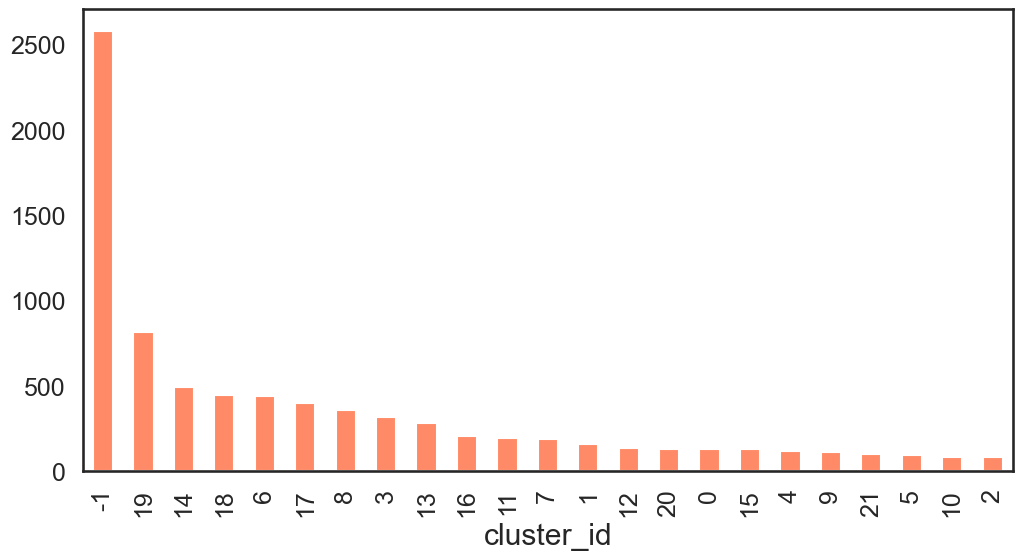

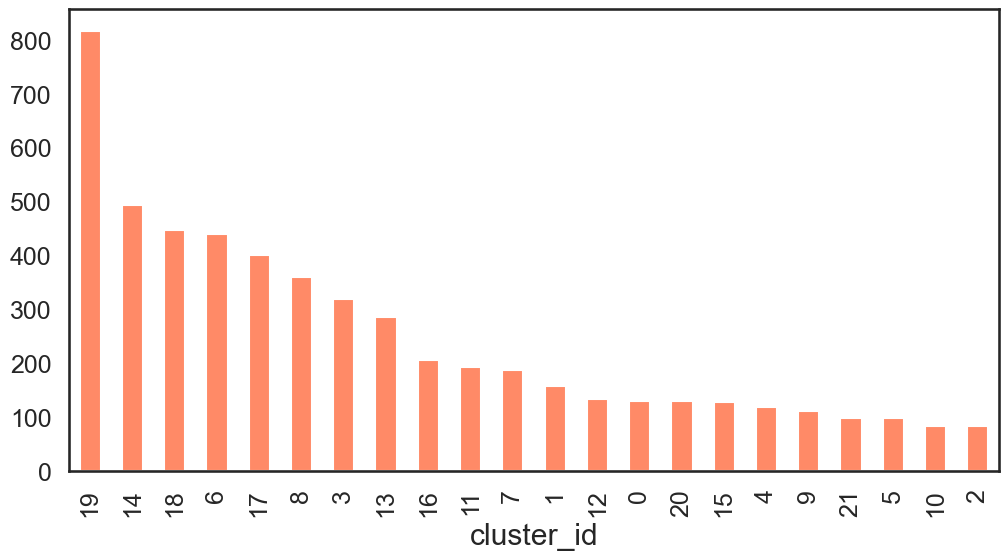

In [7]:
# Plot cluster sizes
df["cluster_id"].value_counts().plot(kind="bar", figsize=(12, 6))
plt.show()

# Plot cluster sizes (no outliers)
df_no_outliers["cluster_id"].value_counts().plot(kind="bar", figsize=(12, 6))
plt.show()

### Visualise Clusters in Latent Space

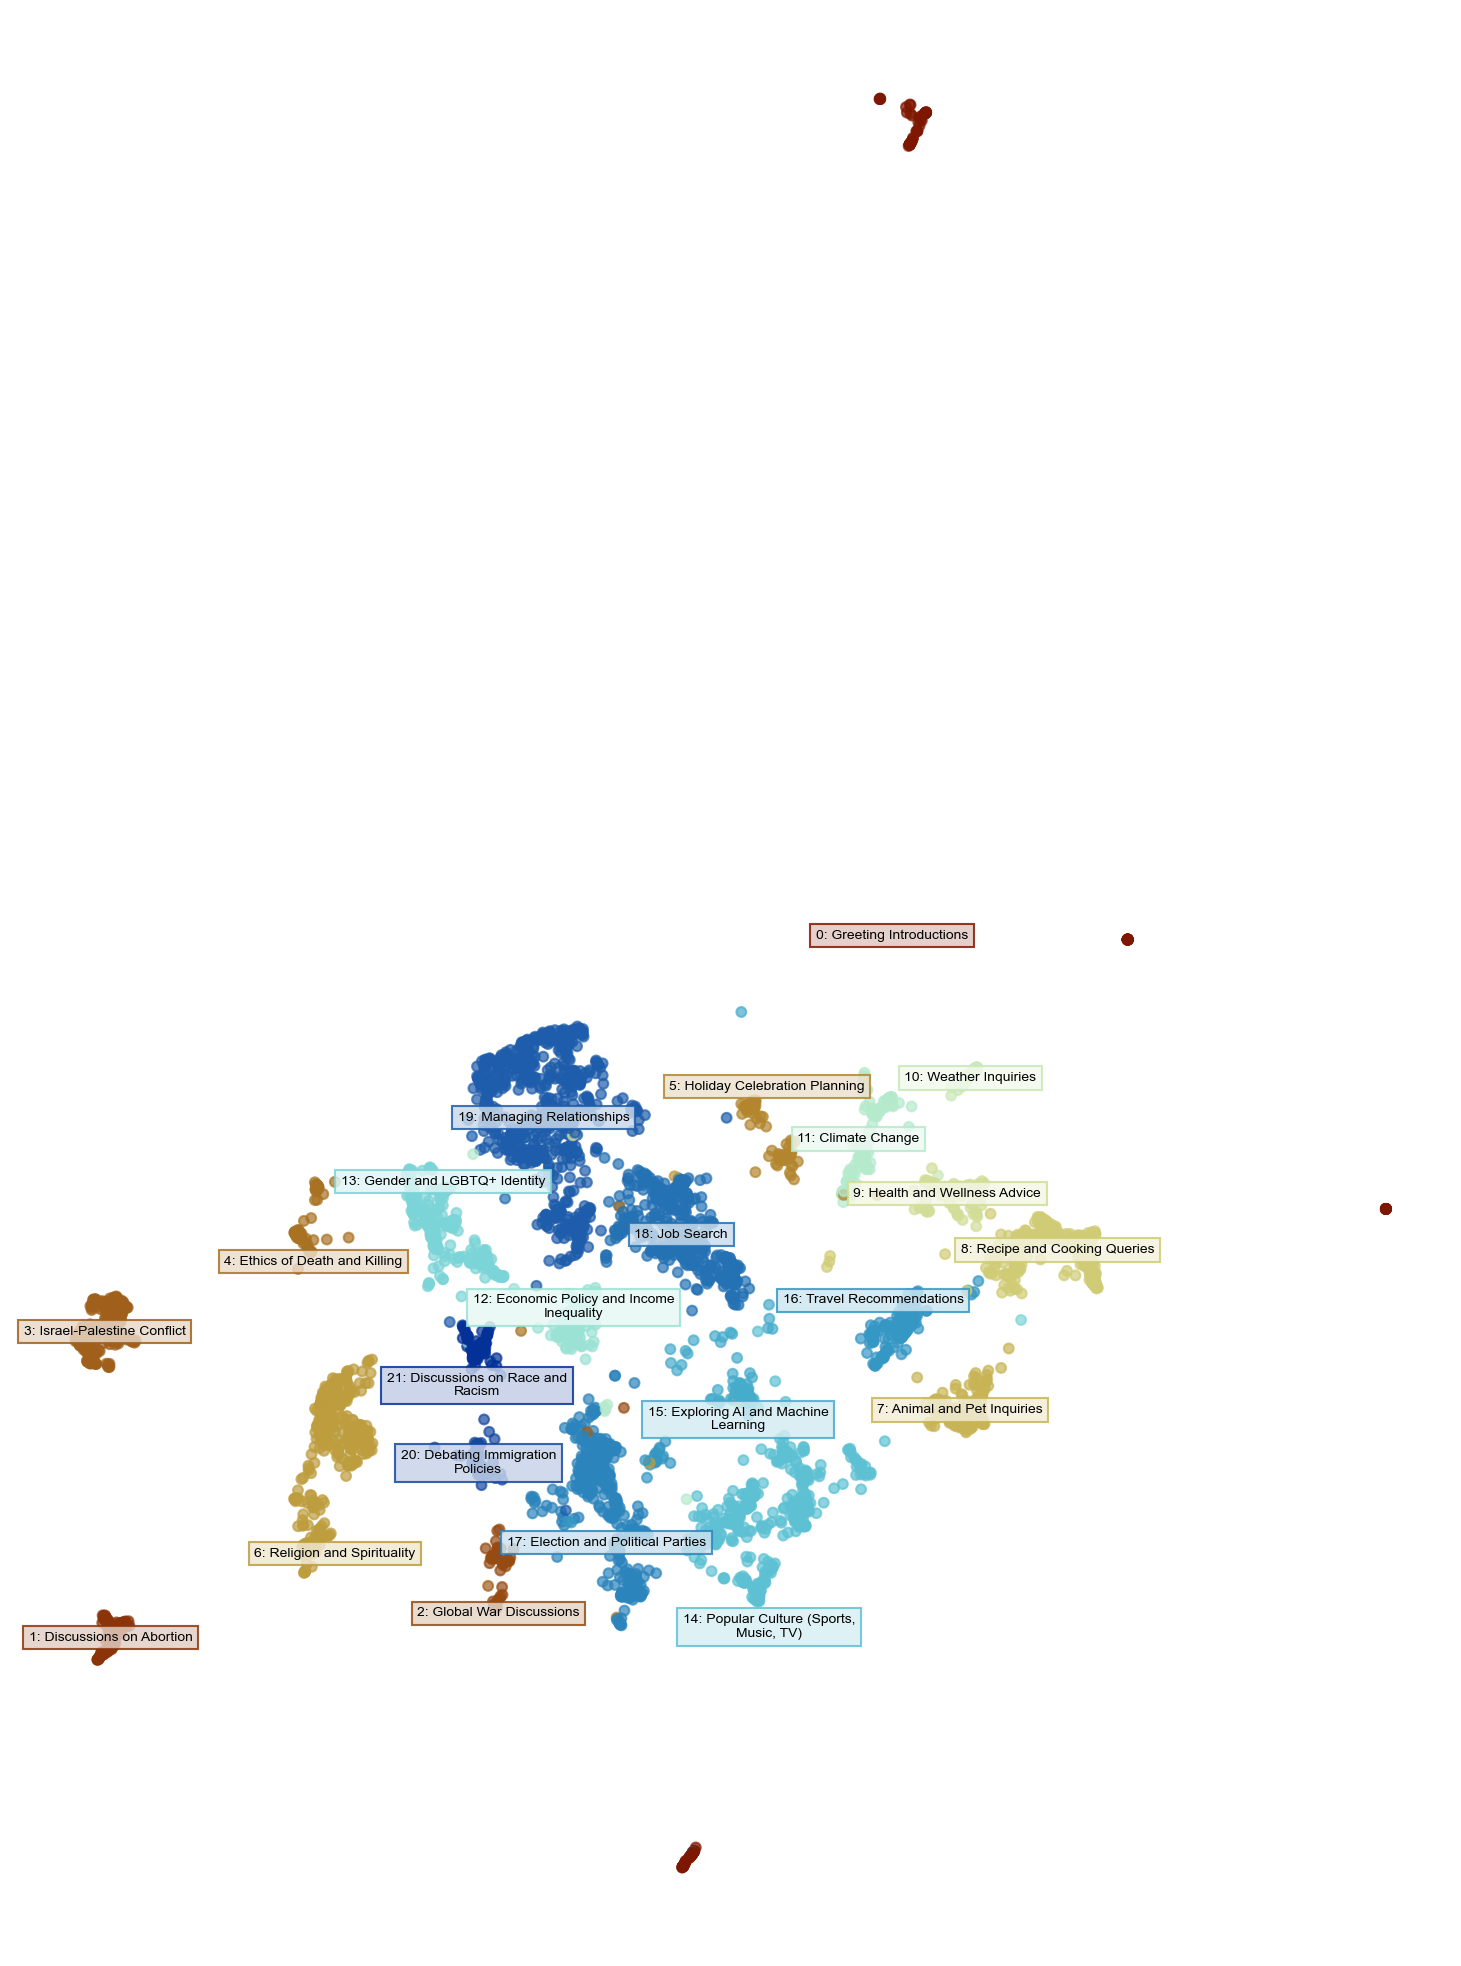

In [8]:
# Define a function for wrapping text
def wrap_text(text, width):
    return "\n".join(textwrap.wrap(text, width))


def visualise_clusters_dense(df_cluster, fig_size: tuple, annot_font_size: int = 8):
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111)

    # Split out -1
    if -1 in df_cluster["cluster_id"].unique():
        print("Outliers found, plotting separately")
        outliers = df_cluster[df_cluster["cluster_id"] == -1]
        ax.scatter(
            outliers["x2"],
            outliers["y2"],
            c="grey",
            alpha=0.1,
            s=50,
            marker="o",
        )
        outlier_str = "_outliers"
    else:
        outlier_str = ""

    # Remove these outliers
    df_cluster = df_cluster[df_cluster["cluster_id"] != -1]

    # Create a colormap and normalize
    cmap = palettes_dict["roma"]
    norm = plt.Normalize(df_cluster["cluster_id"].min(), df_cluster["cluster_id"].max())
    cluster_colors = cmap(norm(df_cluster["cluster_id"]))

    ## PLOT
    ax.scatter(
        df_cluster["x2"],
        df_cluster["y2"],
        c=cluster_colors,
        alpha=0.7,
        s=50,
        marker="o",
    )

    ## ANNOTATE
    plttexts = []
    ids_up_nudge = [5, 16, 13]
    ids_down_nudge = [15, 4, 2, 21, 17]
    ids_down_big = [6, 14]
    ids_tiny_nudge_up = [12]

    # Process each cluster for annotation
    for cluster_id in df_cluster["cluster_id"].unique():
        if cluster_id == -1:
            continue
        else:
            temp_df = df_cluster[df_cluster["cluster_id"] == cluster_id]
            centroid_x, centroid_y = np.mean(temp_df["x2"]), np.mean(temp_df["y2"])

            representative_row = temp_df.iloc[
                (temp_df[["x2", "y2"]] - np.array([centroid_x, centroid_y]))
                .pow(2)
                .sum(1)
                .argmin()
            ]

            wrap_width = random.randint(30, 40)
            wrapped_text = wrap_text(
                str(
                    f"{representative_row.cluster_id}: {representative_row.gpt_description}"
                ),
                width=wrap_width,
            )
            cluster_color = cmap(norm(cluster_id))

            if cluster_id in ids_up_nudge:
                x_offset, y_offset = 0, 0.53
            elif cluster_id in ids_down_nudge:
                x_offset, y_offset = 0, -0.45
            elif cluster_id in ids_down_big:
                x_offset, y_offset = 0, -1.34
            elif cluster_id in ids_tiny_nudge_up:
                x_offset, y_offset = 0, 0.2
            else:
                x_offset, y_offset = 0, 0
            plttexts.append(
                ax.text(
                    centroid_x + x_offset,
                    centroid_y + y_offset,
                    wrapped_text,
                    fontsize=annot_font_size,
                    color="black",
                    bbox=dict(
                        facecolor=cluster_color, alpha=0.2, edgecolor=cluster_color
                    ),
                    ha="center",
                    va="center",
                    zorder=2,
                )
            )
            # Dummy box
            plttexts.append(
                ax.text(
                    centroid_x + x_offset,
                    centroid_y + y_offset,
                    wrapped_text,
                    fontsize=annot_font_size,
                    color="white",
                    bbox=dict(facecolor="white", alpha=0.8, edgecolor=cluster_color),
                    ha="center",
                    va="center",
                    zorder=1,
                )
            )

    # Removing axis borders and y-axis labels
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.yticks([])  # Remove y-axis labels
    plt.gca().xaxis.set_major_locator(plt.NullLocator())

    # Save
    plt.tight_layout()
    plt.savefig(
        f"{PLOT_PATH}/latent_clusters{outlier_str}.pdf",
        format="pdf",
        bbox_inches="tight",
    )

    plt.show()


visualise_clusters_dense(df_no_outliers, (15, 20), annot_font_size=10)

## Exploring Identity and Topic Prevalence

### Basic Overview

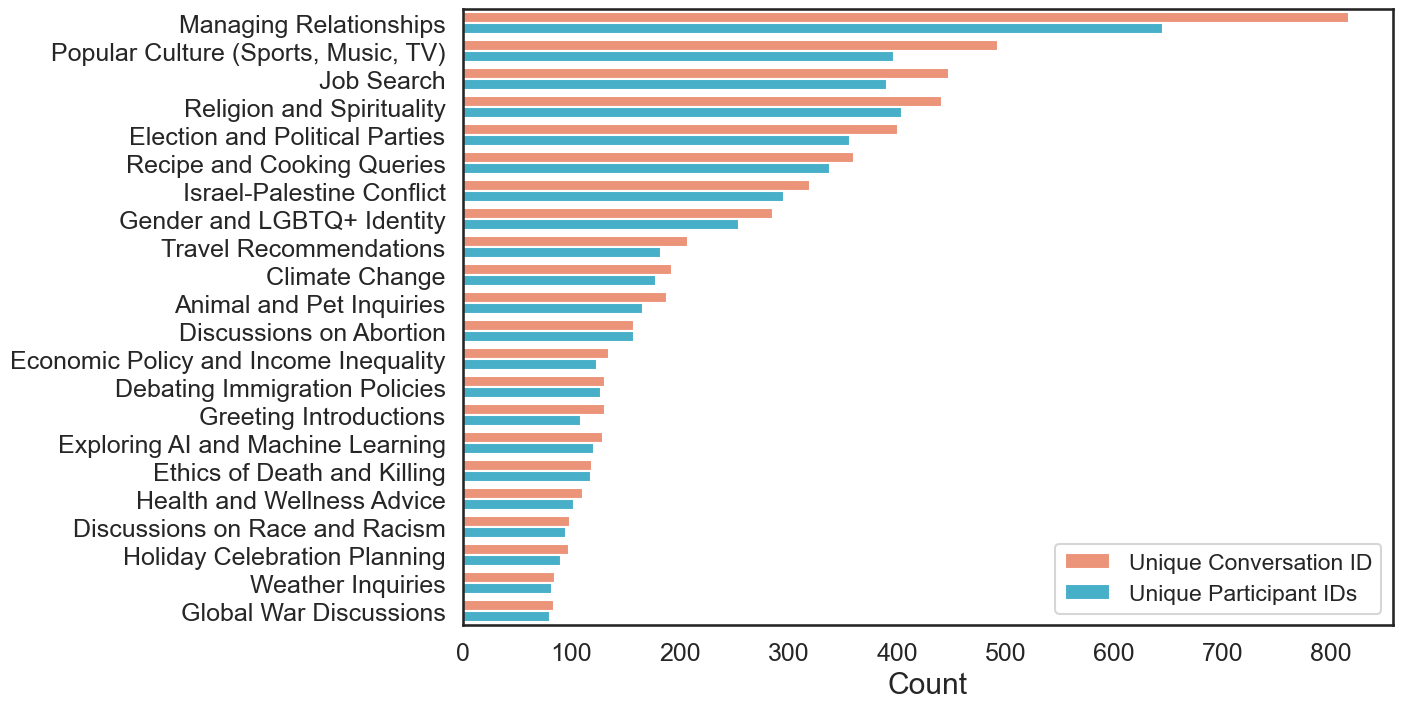

In [9]:
# Count of conversation_id
conv_counts = (
    df_no_outliers.groupby("gpt_description")["conversation_id"].nunique().reset_index()
)
conv_counts["Type"] = "Unique Conversation ID"
conv_counts = conv_counts.rename(columns={"conversation_id": "Count"})

# Count of user_id
user_counts = (
    df_no_outliers.groupby("gpt_description")["user_id"].nunique().reset_index()
)
user_counts["Type"] = "Unique Participant IDs"
user_counts = user_counts.rename(columns={"user_id": "Count"})

# Combine into one dataframe for plotting
combined_counts = pd.concat([conv_counts, user_counts], axis=0)
combined_counts.columns = ["Cluster", "Count", ""]
combined_counts.sort_values(by=["Count"], inplace=True, ascending=False)

# Plotting horizontal bar chart
fig = plt.figure(figsize=(12, 8))
sns.barplot(data=combined_counts, y="Cluster", x="Count", hue="", orient="h")
plt.xticks(rotation=0)  # Rotate labels if needed
# Turn off y-label
plt.ylabel("")
plt.show()

# Save the figure
fig.savefig(f"{PLOT_PATH}/cluster_counts_by_id.pdf", format="pdf", bbox_inches="tight")

In [10]:
# Calculate ratios of unique user IDs to unique conversation IDs
combined_counts["Ratio"] = (
    combined_counts[combined_counts[""] == "Unique Conversation ID"]["Count"]
    / combined_counts[combined_counts[""] == "Unique Participant IDs"]["Count"]
)
combined_counts.sort_values(by=["Ratio"], inplace=True, ascending=False)

# Display
display(combined_counts.head(10))
display(combined_counts.tail(10))

Cluster  Count                          \
16               Managing Relationships    816  Unique Conversation ID   
16               Managing Relationships    645  Unique Participant IDs   
17  Popular Culture (Sports, Music, TV)    397  Unique Participant IDs   
17  Popular Culture (Sports, Music, TV)    493  Unique Conversation ID   
11               Greeting Introductions    131  Unique Conversation ID   
11               Greeting Introductions    109  Unique Participant IDs   
15                           Job Search    391  Unique Participant IDs   
15                           Job Search    448  Unique Conversation ID   
0              Animal and Pet Inquiries    188  Unique Conversation ID   
0              Animal and Pet Inquiries    166  Unique Participant IDs   

       Ratio  
16  1.265116  
16  1.265116  
17  1.241814  
17  1.241814  
11  1.201835  
11  1.201835  
15  1.145780  
15  1.145780  
0   1.132530  
0   1.132530

Cluster  Count                             Ratio
4   Discussions on Race and Racism     99  Unique Conversation ID  1.042105
4   Discussions on Race and Racism     95  Unique Participant IDs  1.042105
21               Weather Inquiries     85  Unique Conversation ID  1.036585
21               Weather Inquiries     82  Unique Participant IDs  1.036585
2    Debating Immigration Policies    127  Unique Participant IDs  1.031496
2    Debating Immigration Policies    131  Unique Conversation ID  1.031496
7      Ethics of Death and Killing    118  Unique Participant IDs  1.008475
7      Ethics of Death and Killing    119  Unique Conversation ID  1.008475
3          Discussions on Abortion    158  Unique Participant IDs  1.000000
3          Discussions on Abortion    158  Unique Conversation ID  1.000000

### Lens of Topic Understanding

We can either at the outer-level, investigate each topic, and at an inner-level investigate demographic breakdowns over this topic. Or, we can start at the outer-level with a demographic, and investigate how authors from this demographic appear in topics.

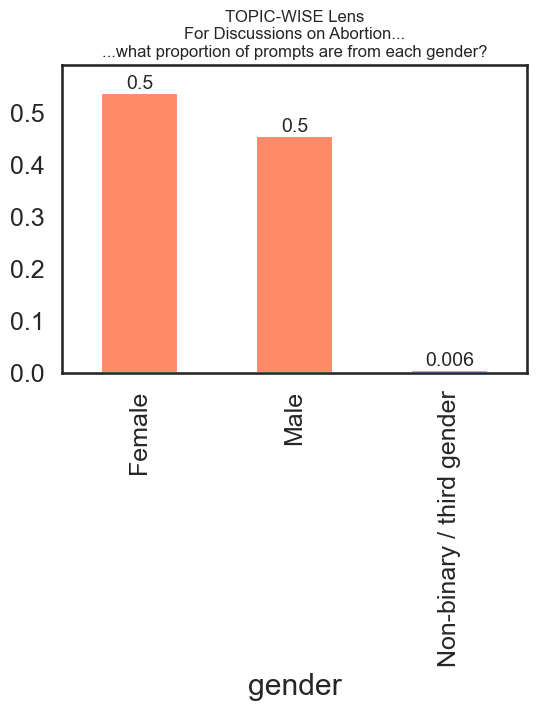

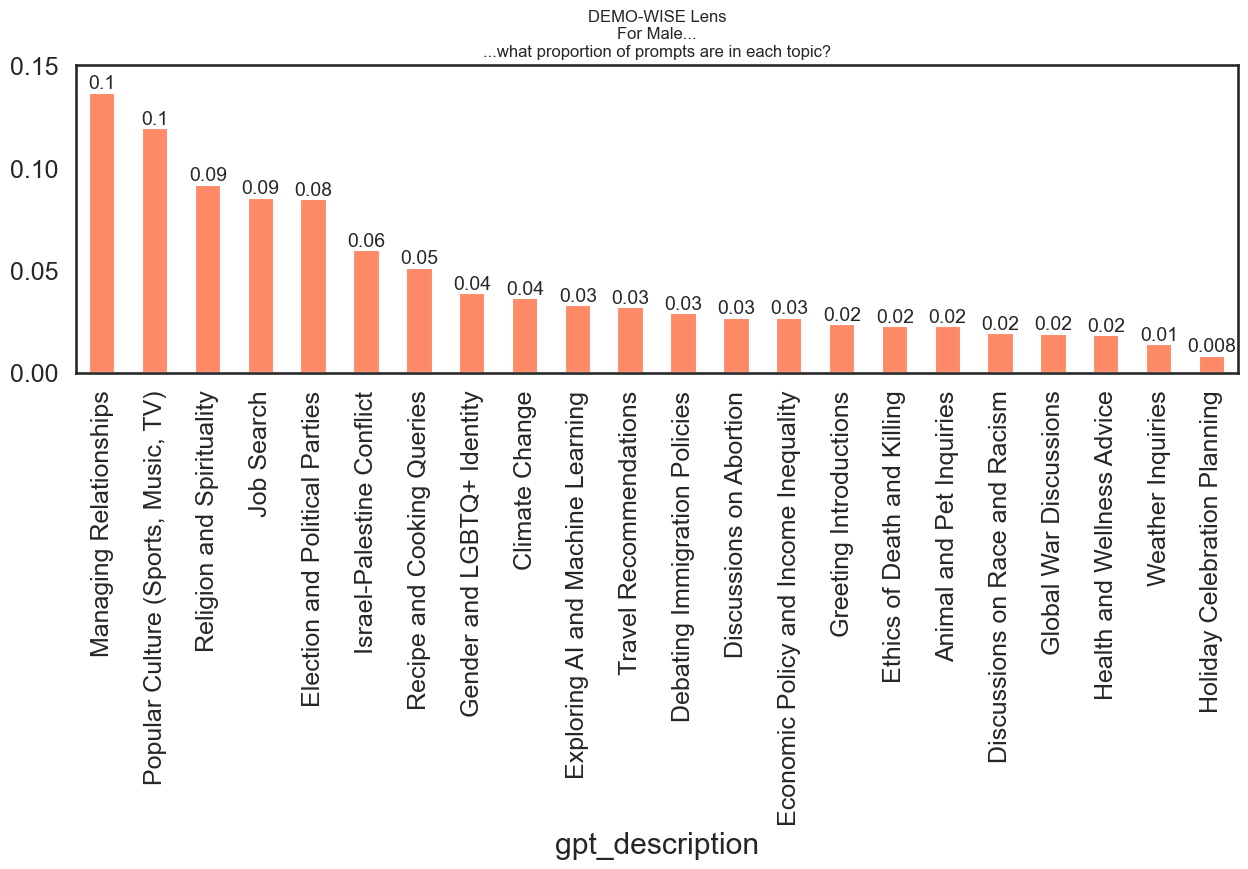

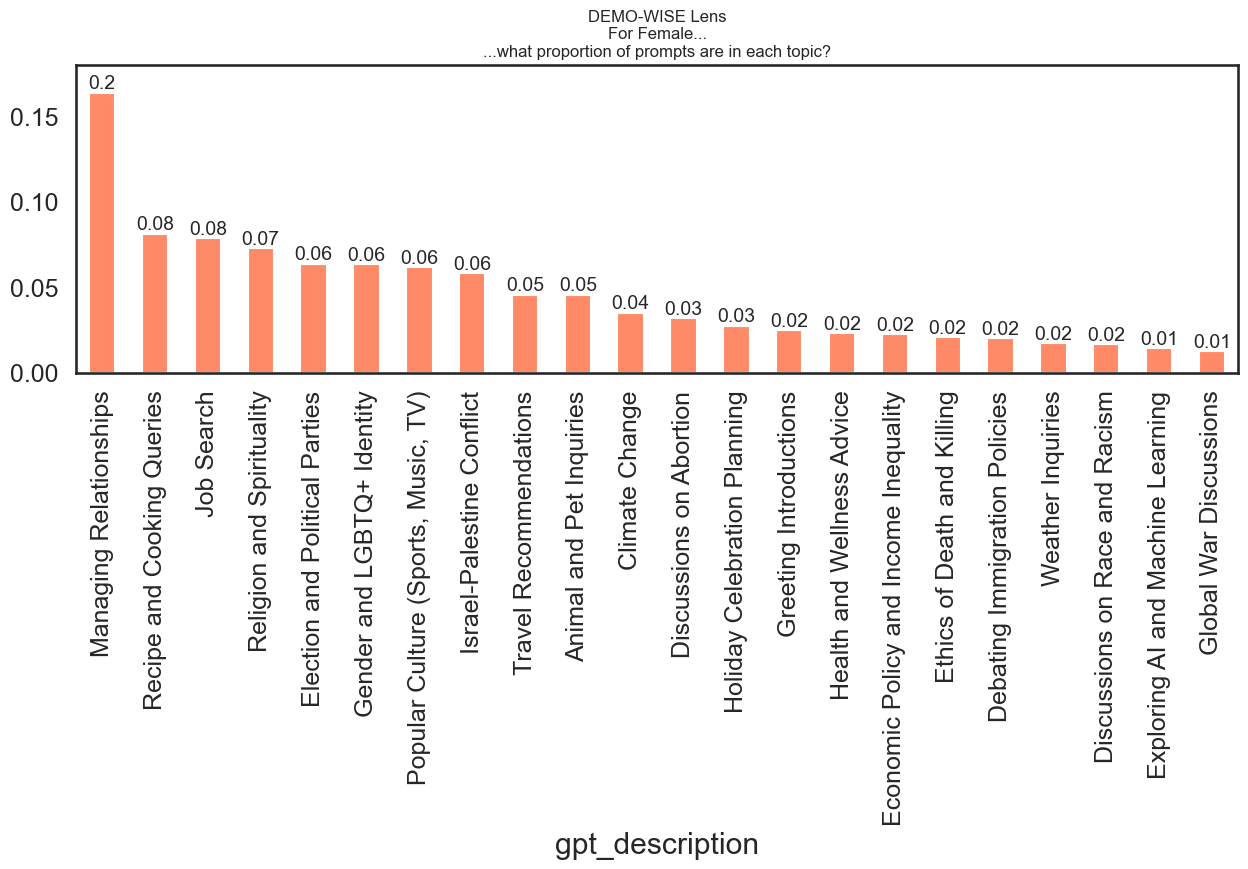

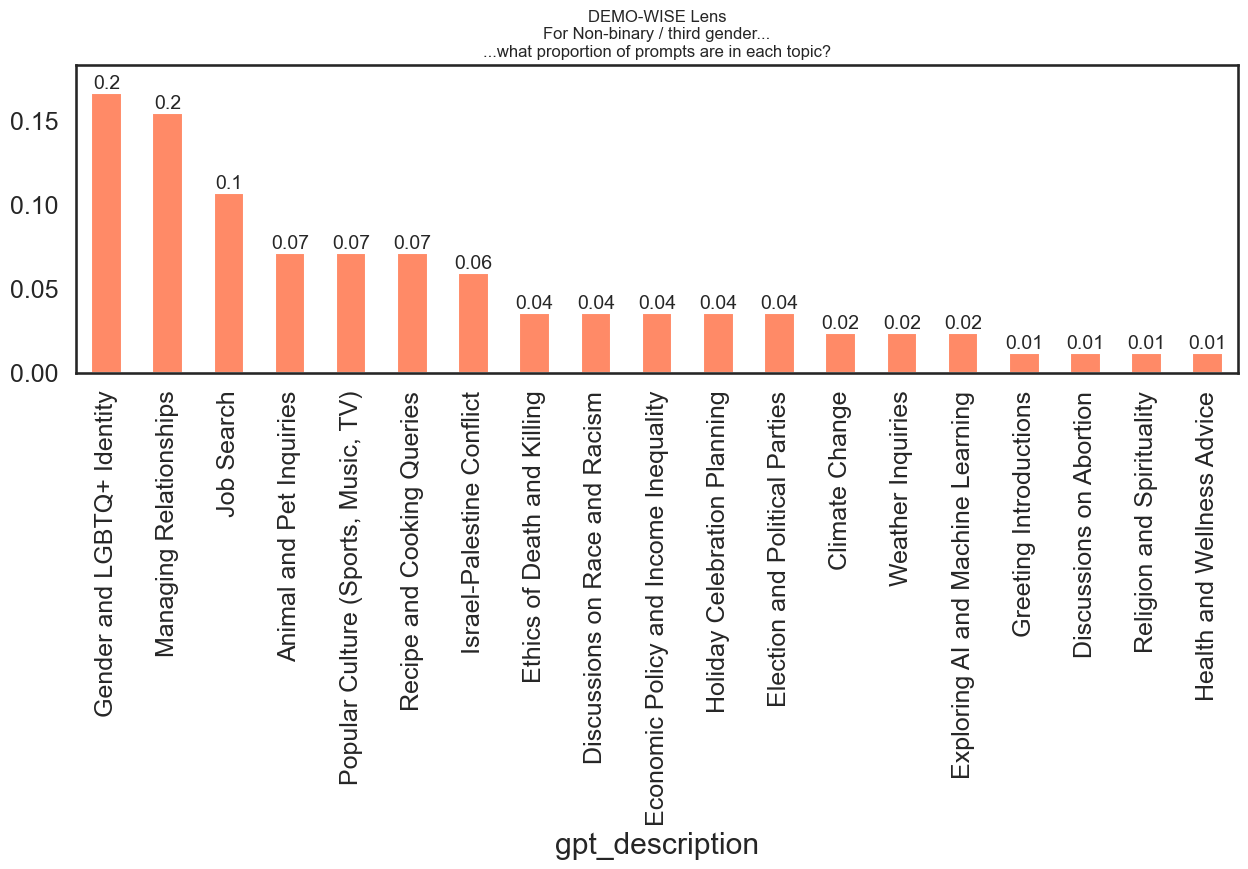

Skipping Prefer not to say as there are only 2 users


In [11]:
# Topic Wise
topic = "Discussions on Abortion"
demo = "gender"
sub_df = df_no_outliers[df_no_outliers["gpt_description"] == topic]
# Plot the counts
fig, ax = plt.subplots(figsize=(6, 4))
counts = sub_df[demo].value_counts(normalize=True)
counts.plot(kind="bar")
# Annotate
for idx, count in enumerate(counts):
    ax.annotate(f"{count:.1}", xy=(idx, count), ha="center", va="bottom", fontsize=14)
# Add some axis padding
ax.margins(0.1)
# Remove y-label
plt.ylabel("")
plt.title(
    f"TOPIC-WISE Lens\nFor {topic}...\n...what proportion of prompts are from each {demo}?",
    fontsize=12,
)
plt.show()

# Demo wise
for attr in df_no_outliers[demo].unique():
    sub_df = df_no_outliers[df_no_outliers[demo] == attr]
    if sub_df["user_id"].nunique() < 20:
        print(f"Skipping {attr} as there are only {sub_df['user_id'].nunique()} users")
        continue
    if attr == "prefer not to say":
        continue
    # Plot the counts
    fig, ax = plt.subplots(figsize=(15, 4))
    counts = sub_df["gpt_description"].value_counts(normalize=True)
    counts.plot(kind="bar")
    # Annotate
    for idx, count in enumerate(counts):
        ax.annotate(
            f"{count:.1}", xy=(idx, count), ha="center", va="bottom", fontsize=14
        )
    # Add some axis padding to y
    ax.margins(0.1)
    # Remove y-label
    plt.ylabel("")
    plt.title(
        f"DEMO-WISE Lens\nFor {attr}...\n...what proportion of prompts are in each topic?",
        fontsize=12,
    )
    plt.show()

### Exploring Observed vs Expected Proportions of Each Demographic in Each Topic

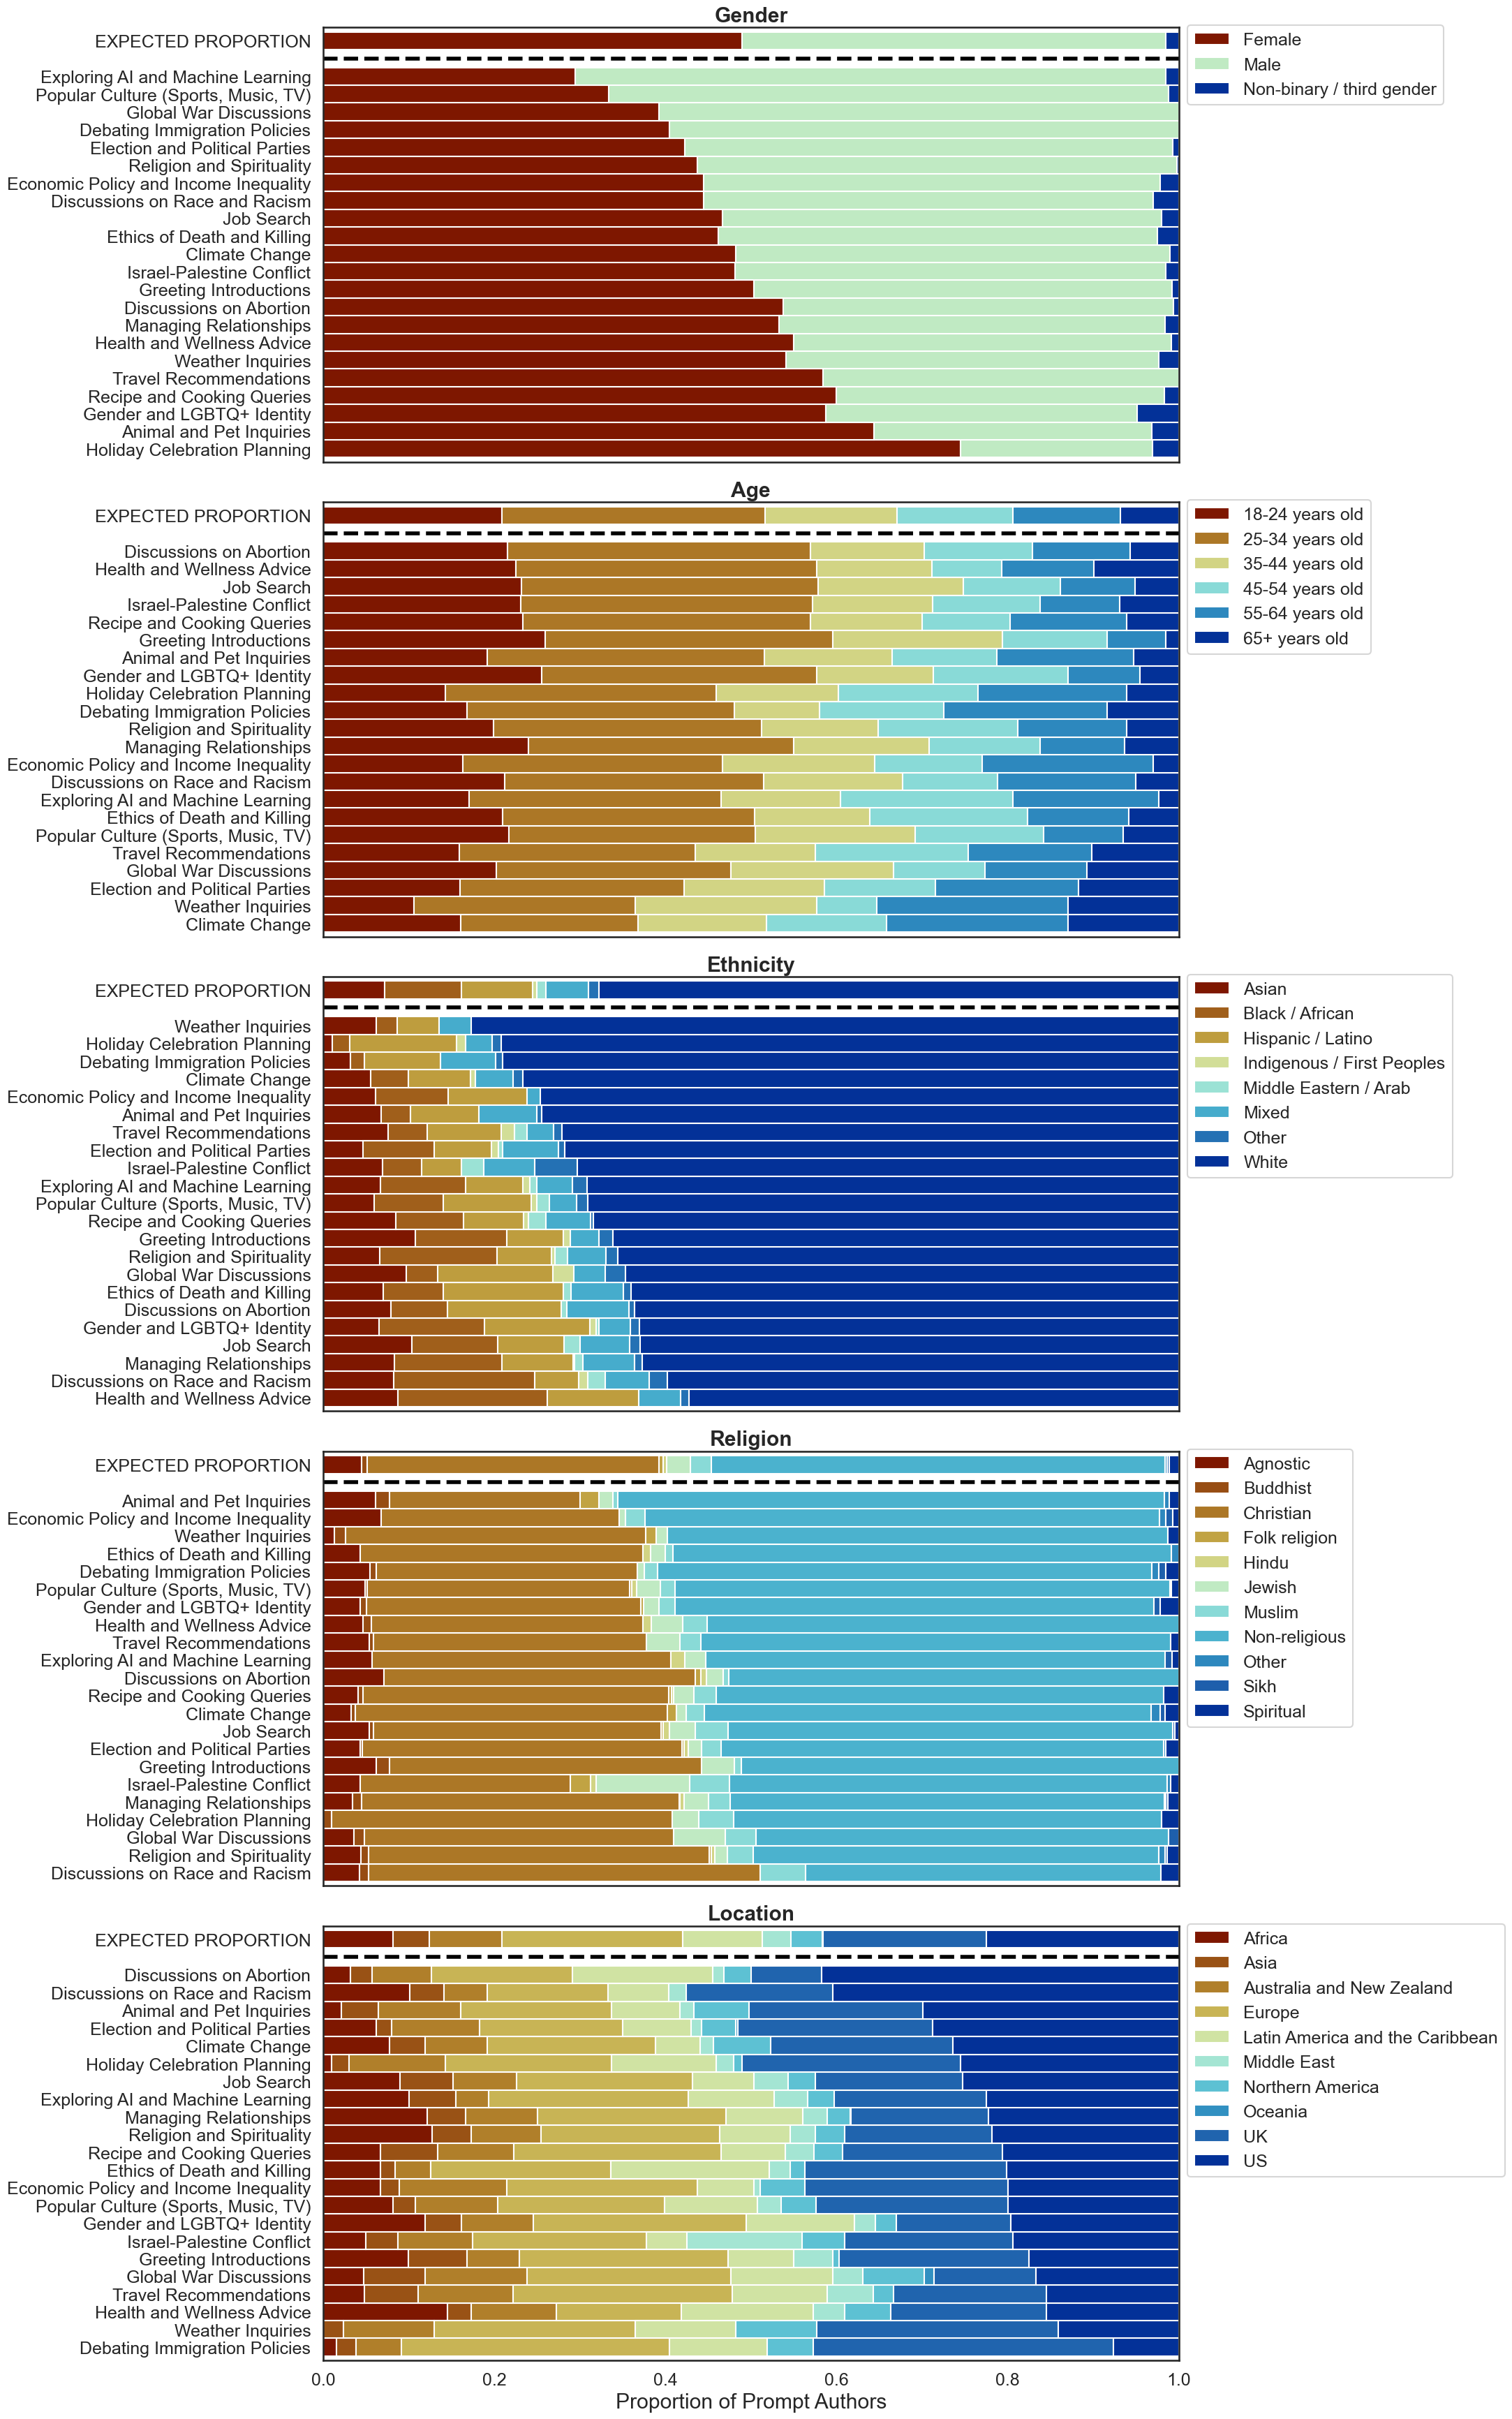

In [12]:
# Setup
demo_cols = ['gender', 'age', 'ethnicity_categorised', 'religion_categorised', 'location_special_region']
palettes = ['roma'] * len(demo_cols)

# Plot
fig, ax = plt.subplots(len(demo_cols), 1, figsize=(22, 20*1.75), sharex = True)

for i, demographic_var in enumerate(demo_cols):
    # Remove Prefer not to say
    plot_df = df_no_outliers[df_no_outliers[demographic_var] != 'Prefer not to say']

    # Calculate the counts of each group within each 'cluster_id'
    grouped = plot_df.groupby(['gpt_description', demographic_var]).size().unstack(fill_value=0)
    # Convert counts to proportions
    order = grouped.sum().sort_values(ascending=False).index.to_list()
    proportions = grouped.div(grouped.sum(axis=1), axis=0).sort_values(by = order)
    # Add a bar for expected proportion as base rate of each demographic subgroup in the population
    expected_proportions = plot_df[demographic_var].value_counts(normalize = True)
    expected_proportions = pd.DataFrame(expected_proportions).transpose()
    expected_proportions.index = ['EXPECTED PROPORTION']
    dummyrow = pd.DataFrame({col: 0 for col in proportions.columns}, index = [''])
    proportions = pd.concat([proportions,dummyrow, expected_proportions,], axis=0)
    palette = palettes[i]
    proportions.plot(kind='barh', stacked=True, ax=ax[i], colormap=palettes_dict[palette], width = 1, edgecolor = 'white')
    # Set axis
    ax[i].set_xlim(0, 1)
    # Horizontal line to seperate expected and observed
    ax[i].axhline(y=len(proportions)-2, color='black', linewidth=4, linestyle = '--')
    # Labels and legend
    ax[i].set_xlabel('Proportion of Prompt Authors')
    ax[i].set_title(f'{demographic_var.split('_')[0].capitalize()}', fontweight = 'semibold')
    ax[i].legend(bbox_to_anchor=(1, 1.025), loc='upper left', fontsize = 18)

# Plot level adjustments
plt.xticks(rotation=0)
# Reduce vertical space between subplots
plt.subplots_adjust(hspace=0.0)
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

#Save
fig.savefig(f"{PLOT_PATH}/expected_topic_proportions_by_demo.pdf", format="pdf", bbox_inches="tight")

### Group Topic Counts

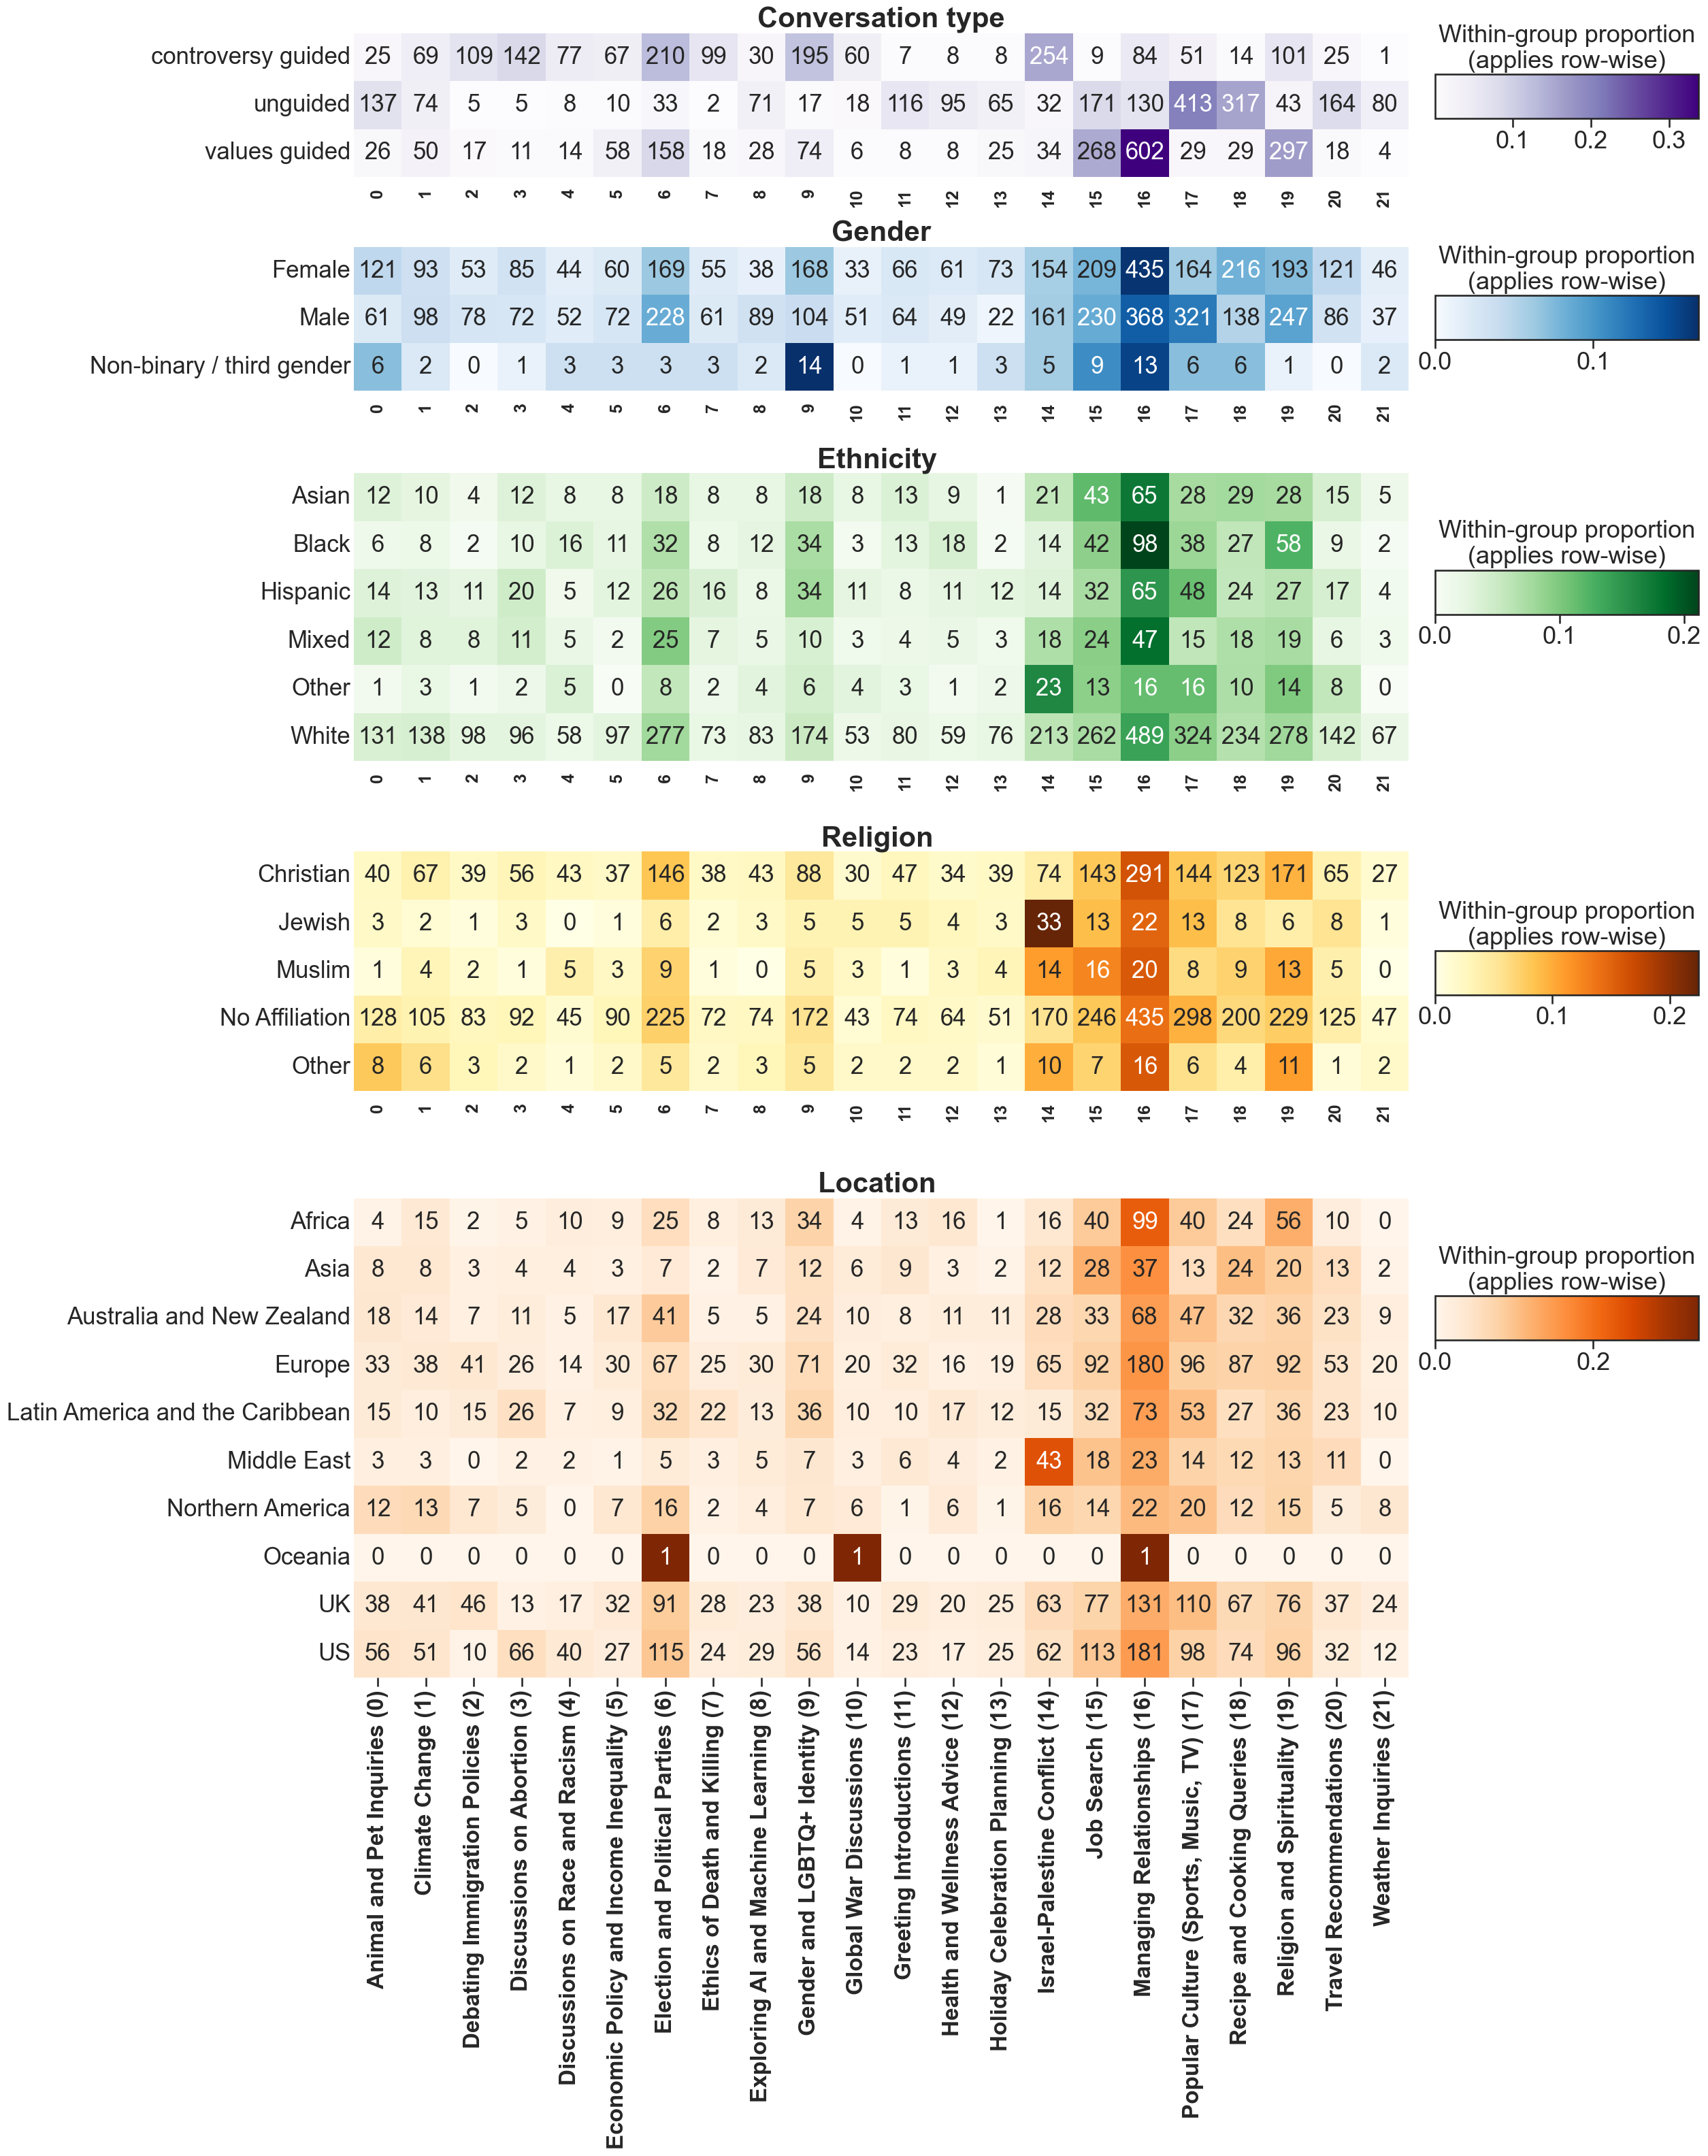

In [13]:
demo_cols = ['conversation_type', 'gender', 'ethnicity_simplified', 'religion_simplified', 'location_special_region']
color_palettes = ['Purples', 'Blues', 'Greens', 'YlOrBr', 'Oranges', 'Reds']

# Calculate subplot heights based on the number of y-axis points
subplot_heights = []
for demographic_var in demo_cols:
    plot_df = df_no_outliers[df_no_outliers[demographic_var] != "Prefer not to say"]
    unique_y_points = plot_df[demographic_var].nunique()
    subplot_heights.append(unique_y_points)  # Adjust based on desired cell size

# Create a mapping of full text labels to numbers
label_mapping = {label: f"{label} ({i})" for i, label in enumerate(sorted(set(df_no_outliers['gpt_description'])))}
number_mapping = {label: str(i) for i, label in enumerate(sorted(set(df_no_outliers['gpt_description'])))}

# Create figure with GridSpec
fig = plt.figure(figsize=(20, sum(subplot_heights) * 1.2))  # Adjust height as needed
gs = GridSpec(len(demo_cols), 1, height_ratios=subplot_heights)

first_ax = None  # Initialize the first ax for sharing x-axis

for i, demographic_var in enumerate(demo_cols):
    # Remove Prefer not to say
    plot_df = df_no_outliers[df_no_outliers[demographic_var] != "Prefer not to say"]
    grouped = plot_df.groupby([demographic_var, "gpt_description"]).size().unstack(fill_value=0)
    # Sort by gpt_description (alphabetical)
    grouped = grouped.reindex(sorted(grouped.columns), axis=1)

    # Convert counts to proportions
    proportions = grouped.div(grouped.sum(axis=1), axis=0)

    ax = plt.subplot(gs[i])
    if i == 0:
        first_ax = ax  # Save the first axes object to share
    cmap = color_palettes[i]
    cax = sns.heatmap(proportions, annot=grouped, fmt="d", cmap=cmap, ax=ax, square=True, cbar=False, annot_kws={"size": 25})
    ax.set_title(f'{demographic_var.capitalize().replace("_", " ").replace('simplified', '').replace('special region', '')}', fontweight='semibold', fontsize = 30)
    ax.set_ylabel('')  # Hide y-axis label
    ax.tick_params(axis='y', which='both', length=0, labelsize = 25)  # Hide y-axis ticks

    if i == len(demo_cols) - 1:
        ax.set_xlabel('')
        ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labelsize = 24)
        labels = [item.get_text() for item in ax.get_xticklabels()]
        str_labels = [f'{label} ({number_mapping[label]})' for label in labels]
        ax.set_xticklabels(str_labels, rotation=90, ha='center', fontweight='bold')
    else:
        ax.set_xlabel('')
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
        labels = [item.get_text() for item in ax.get_xticklabels()]
        numeric_labels = [number_mapping[label] for label in labels]
        ax.set_xticklabels(numeric_labels, rotation=90, ha='center', fontweight='bold')

    # Position and resize the cbar above the heatmap
    if i == 0:
        gap = 0.04
    elif i < 2:
        gap = 0.04
    else:
        gap = 0.06
    color_bar_width = ax.get_position().width * 0.25  # Adjust the width
    cbar_ax = fig.add_axes([
        ax.get_position().x1 + (ax.get_position().width - color_bar_width) / 30,  # Horizontal alignment of cbar
        (ax.get_position().y1)-gap, #Small gap above the heatmap
        color_bar_width,
        0.02  # Height of cbar
    ])
    cbar = fig.colorbar(cax.collections[0], cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=26)  # Adjust cbar tick label size

    # Add text annotation above the cbar
    fig.text(
        cbar_ax.get_position().x0 + cbar_ax.get_position().width / 2,  # Centered above the cbar
        cbar_ax.get_position().y1+0.0008,  # Small gap above the cbar
        'Within-group proportion\n(applies row-wise)',
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=26 # Font size
    )

plt.subplots_adjust(hspace=0.15)  # Adjust spacing between subplots
plt.show()

# Save
fig.savefig(f"{PLOT_PATH}/heatmap_topic_proportions_by_demo.pdf", format="pdf", bbox_inches="tight")

### Topic Regressions

We load and examine the topic regressions produced in `topic_regressions.R`

In [14]:
reg_df = pd.read_csv(f"{CLUSTER_PATH}/topic_regression_tests.csv")

display(reg_df.head(2))

print(reg_df["coefficient"].value_counts().to_dict())

cluster_id           cluster_name                      coefficient  \
0           0  GreetingIntroductions                     genderFemale   
1           0  GreetingIntroductions  genderNon-binary / third gender   

   estimate    pval  significant_99pc  
0    0.0005  0.8690                 0  
1   -0.0093  0.2805                 0

{'genderFemale': 22, 'regionPrefer not to say': 22, 'conversation_typecontroversy guided': 22, 'religionPrefer not to say': 22, 'religionOther': 22, 'religionMuslim': 22, 'religionJewish': 22, 'religionChristian': 22, 'ethnicityPrefer not to say': 22, 'ethnicityOther': 22, 'ethnicityMixed': 22, 'ethnicityHispanic': 22, 'ethnicityBlack': 22, 'ethnicityAsian': 22, 'regionUK': 22, 'regionOceania': 22, 'genderNon-binary / third gender': 22, 'regionNorthern America': 22, 'regionMiddle East': 22, 'regionLatin America and the Caribbean': 22, 'regionEurope': 22, 'regionAustralia and New Zealand': 22, 'regionAsia': 22, 'regionAfrica': 22, 'age65+ years old': 22, 'age55-64 years old': 22, 'age45-54 years old': 22, 'age35-44 years old': 22, 'age25-34 years old': 22, 'genderPrefer not to say': 22, 'conversation_typevalues guided': 22}


In [15]:
# Get names from df_no_outliers as a dictionary to map onto this dataframe
cluster_names = df_no_outliers[["cluster_id", "gpt_description"]]
# Turn into dictionary
id2name = cluster_names.set_index("cluster_id").to_dict()["gpt_description"]
# And create the other way
name2id = {v: k for k, v in id2name.items()}
reg_df["cluster_name"] = reg_df["cluster_id"].map(id2name)
reg_df["cluster_name"].value_counts(dropna=False)

cluster_name
Greeting Introductions                   31
Discussions on Abortion                  31
Debating Immigration Policies            31
Managing Relationships                   31
Job Search                               31
Election and Political Parties           31
Travel Recommendations                   31
Exploring AI and Machine Learning        31
Popular Culture (Sports, Music, TV)      31
Gender and LGBTQ+ Identity               31
Economic Policy and Income Inequality    31
Climate Change                           31
Weather Inquiries                        31
Health and Wellness Advice               31
Recipe and Cooking Queries               31
Animal and Pet Inquiries                 31
Religion and Spirituality                31
Holiday Celebration Planning             31
Ethics of Death and Killing              31
Israel-Palestine Conflict                31
Global War Discussions                   31
Discussions on Race and Racism           31
Name: count, dtype:

In [16]:
# Split out demo col
demos = ["gender", "age", "ethnicity", "region", "conversation_type", "religion"]


def check_demo(x):
    # Split demographic and group string, and map back to original names
    for demo in demos:
        if demo in x:
            demo_portion = demo
            group_portion = x.replace(demo, "")
            if "region" in demo_portion:
                demo_portion = "location_special_region"
            if "Non-binary" in group_portion:
                group_portion = "Non-binary / third gender"
            if demo_portion in ["ethnicity", "religion"]:
                demo_portion = f"{demo_portion}_simplified"
            return demo_portion, group_portion
    return np.nan, np.nan


# Apply and create two new columns "demo", "group":
reg_df["demo"], reg_df["group"] = zip(*reg_df["coefficient"].map(check_demo))

# Display
reg_df.head(2)

# Rehash coefficient now for a clean label
reg_df["coefficient"] = reg_df["demo"] + ": " + reg_df["group"]

print(reg_df["coefficient"].value_counts(dropna=False))

coefficient
gender: Female                                              22
location_special_region: Prefer not to say                  22
conversation_type: controversy guided                       22
religion_simplified: Prefer not to say                      22
religion_simplified: Other                                  22
religion_simplified: Muslim                                 22
religion_simplified: Jewish                                 22
religion_simplified: Christian                              22
ethnicity_simplified: Prefer not to say                     22
ethnicity_simplified: Other                                 22
ethnicity_simplified: Mixed                                 22
ethnicity_simplified: Hispanic                              22
ethnicity_simplified: Black                                 22
ethnicity_simplified: Asian                                 22
location_special_region: UK                                 22
location_special_region: Oceania           

In [17]:
# Check significant results
print("With Convo Type")
print(reg_df["significant_99pc"].value_counts(dropna=False))

print(reg_df["significant_99pc"].value_counts(normalize=True, dropna=False))

print(f"Number of tests: {len(reg_df)}")

print("Demographics Only")
reg_df_demo_only = reg_df[reg_df["demo"] != "conversation_type"]
print(reg_df_demo_only["significant_99pc"].value_counts(dropna=False))

print(reg_df_demo_only["significant_99pc"].value_counts(normalize=True, dropna=False))

print(f"Number of demo tests: {len(reg_df_demo_only)}")

With Convo Type
significant_99pc
0    572
1    110
Name: count, dtype: int64
significant_99pc
0    0.83871
1    0.16129
Name: proportion, dtype: float64
Number of tests: 682
Demographics Only
significant_99pc
0    565
1     73
Name: count, dtype: int64
significant_99pc
0    0.88558
1    0.11442
Name: proportion, dtype: float64
Number of demo tests: 638


In [18]:
filtered_df = reg_df.copy()
# For plot, remove any variables with less than threshold group members
for demo in reg_df["demo"].unique():
    for group in reg_df[reg_df["demo"] == demo]["group"].unique():
        n_members = df_no_outliers[df_no_outliers[demo] == group].shape[0]
        if n_members < 20:
            print(f"Removing {demo}:{group} as it has only {n_members} members")
            filtered_df = filtered_df[
                (filtered_df["demo"] != demo) | (filtered_df["group"] != group)
            ]

Removing gender:Prefer not to say as it has only 3 members
Removing location_special_region:Oceania as it has only 3 members
Removing location_special_region:Prefer not to say as it has only 10 members


In [19]:
def clean_group_label(s):
    s = (
        s.replace(" and ", " & ")
        .replace("_", " ")
        .replace(" simplified", "")
        .replace("conversation", "convo")
        .replace(" special region:", ":")
        .strip()
    )
    if "Non-binary" in s:
        return "Non-binary"
    if "years old" in s:
        return s.replace(" years old", "")
    elif "Latin America" in s:
        return "location: Latam"
    elif "Northern" in s:
        return "location: N. America"
    elif "Australia" in s:
        return "location: Aus & NZ"
    return s

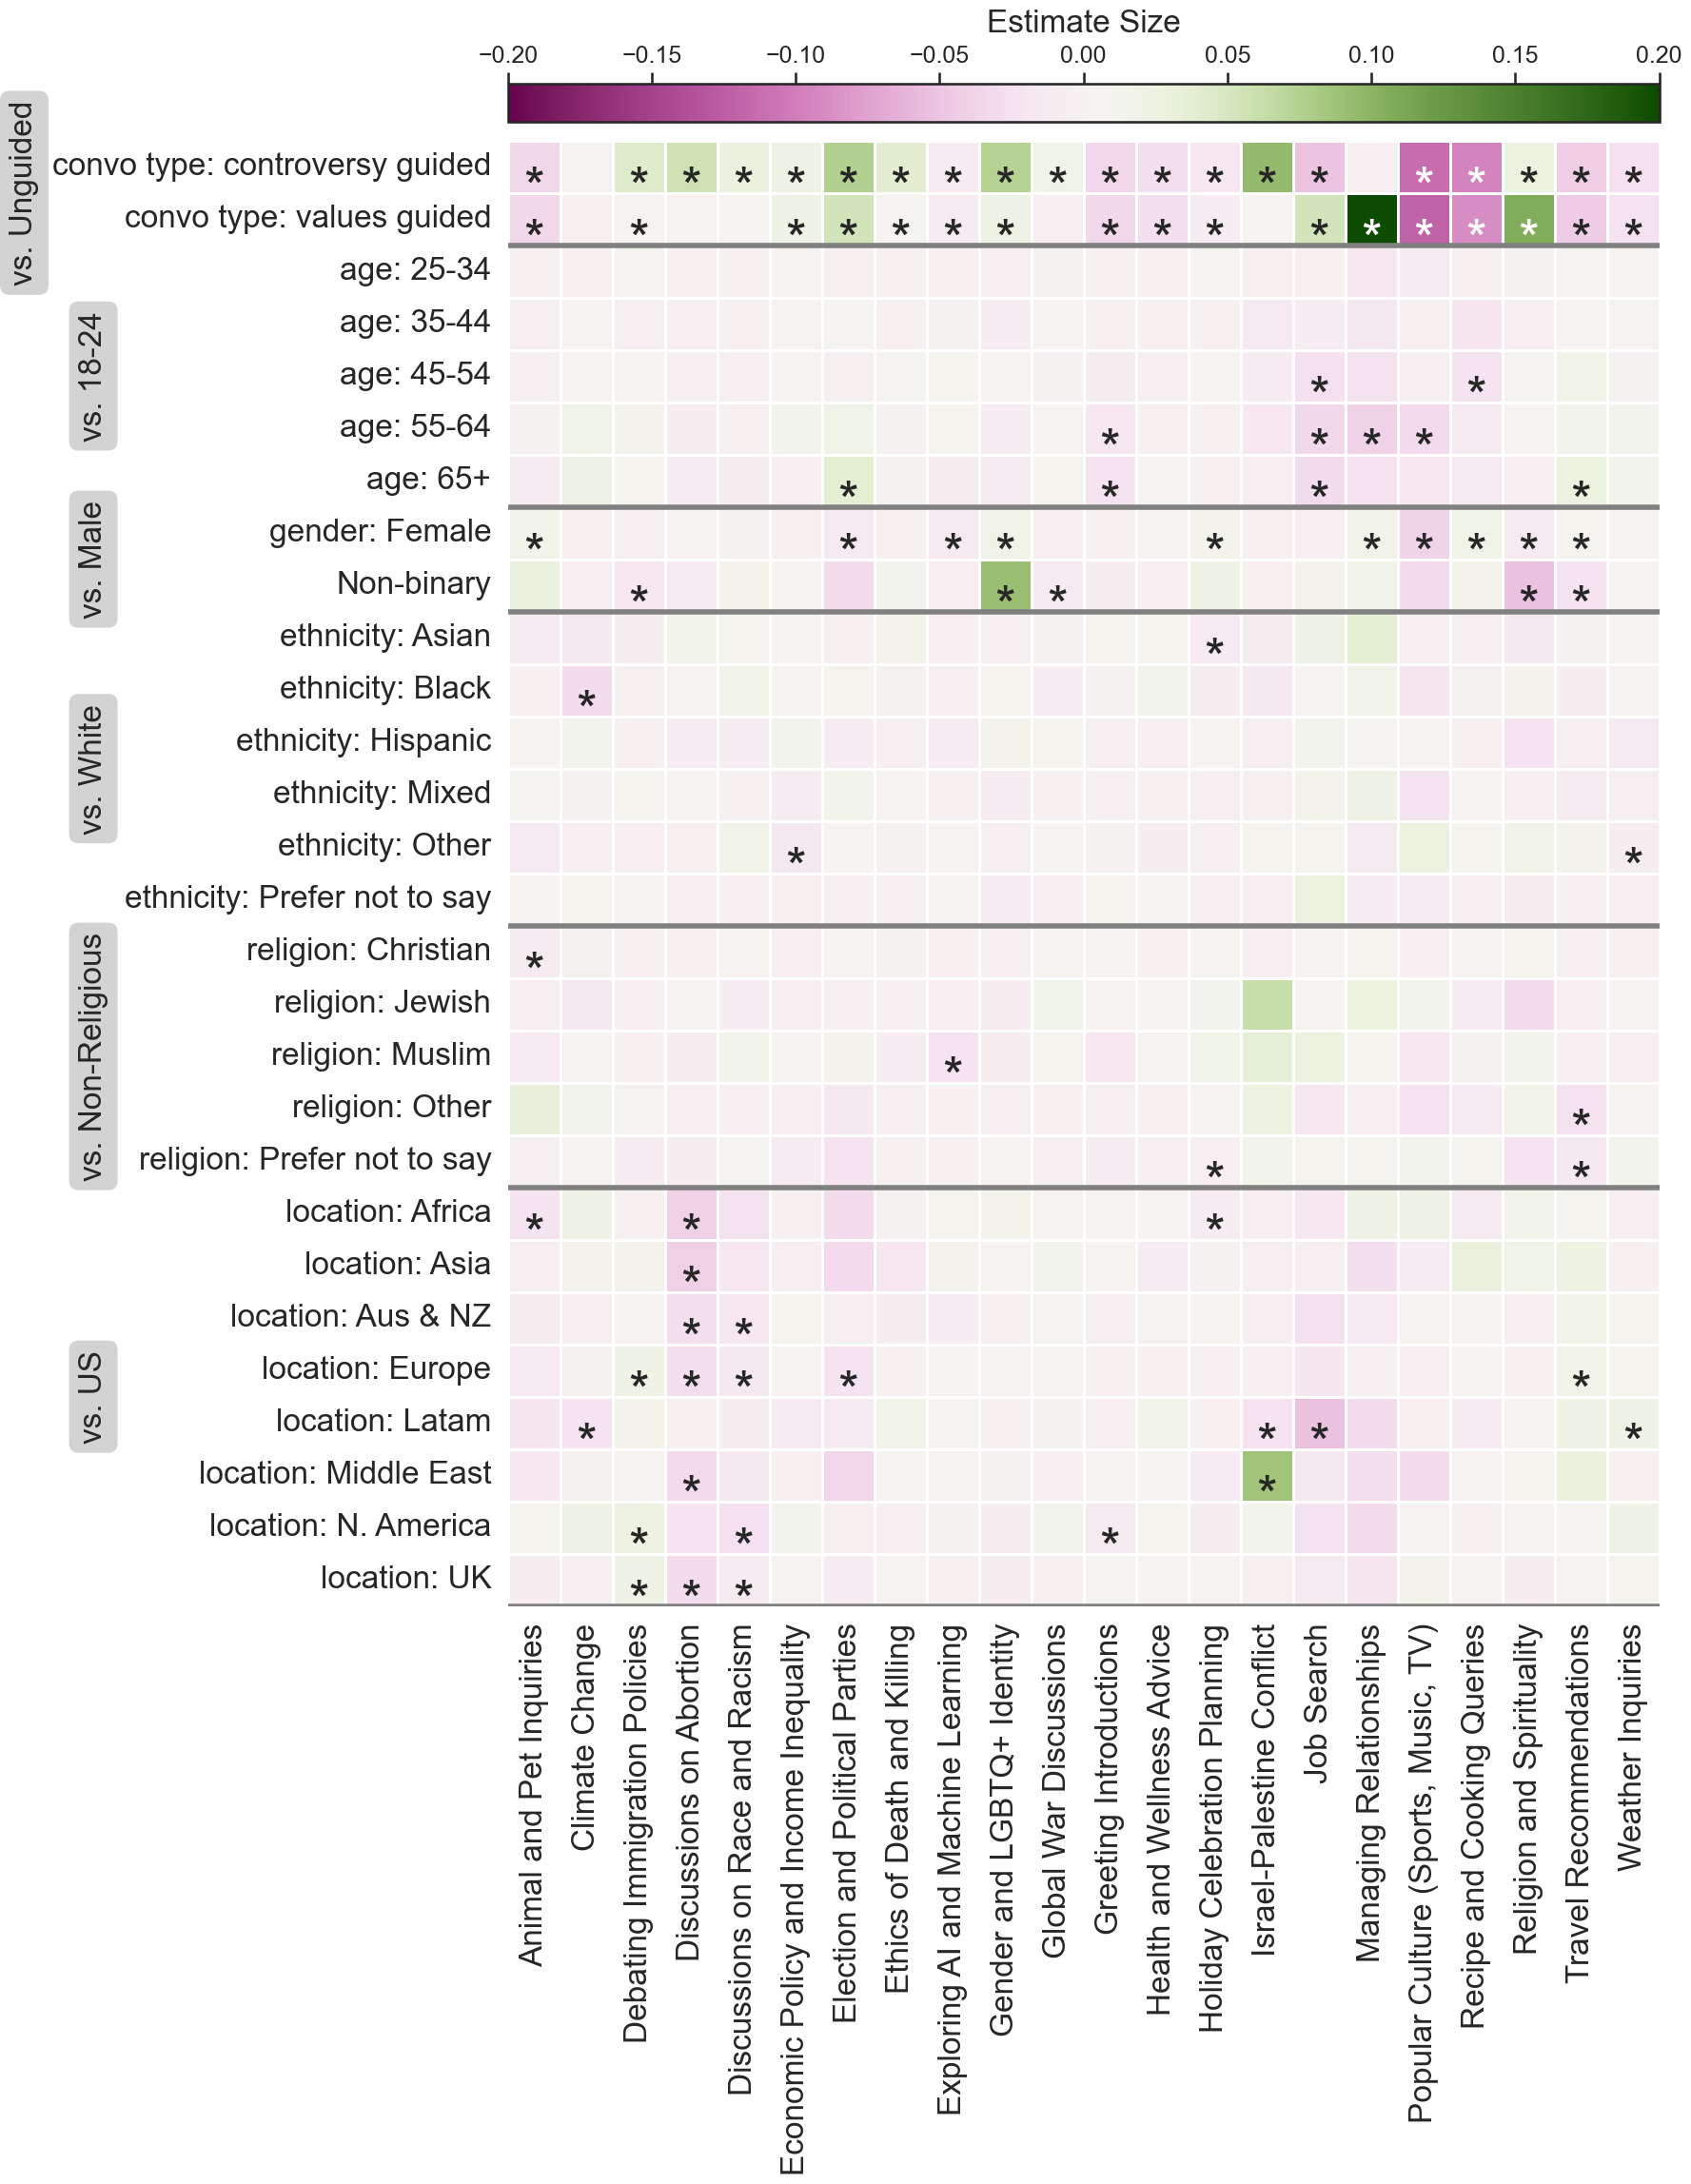

In [20]:
# Specify demo order
demo_order = [
    "conversation_type",
    "age",
    "gender",
    "ethnicity_simplified",
    "religion_simplified",
    "location_special_region",
]
x_var = "cluster_name"
y_var = "coefficient"

# Pivot for heatmap
heatmap_data = filtered_df.pivot(index=y_var, columns=x_var, values="estimate")
#
if y_var == "coefficient":
    # Sort the rows by demo_order
    index_order = []
    for demo in demo_order:
        index_order.extend(heatmap_data.index[heatmap_data.index.str.contains(demo)])
    heatmap_data = heatmap_data.reindex(index_order)
elif x_var == "coefficient":
    # Sort the columns by demo_order
    col_order = []
    for demo in demo_order:
        col_order.extend(heatmap_data.columns[heatmap_data.columns.str.contains(demo)])
    print(col_order)
    heatmap_data = heatmap_data[col_order]

# Pivot for significance data
significance_data = reg_df.pivot(index=y_var, columns=x_var, values="significant_99pc")
if y_var == "coefficient":
    # Sort the rows
    significance_data = significance_data.reindex(heatmap_data.index)
elif x_var == "coefficient":
    # Sort columns
    significance_data = significance_data[heatmap_data.columns]

# Create annotation array with stars where significant
annotations = significance_data.map(lambda x: "*" if x == 1 else "")

# Count stars to check if it matches the count in the original dataframe
count = 0
for c in annotations.columns:
    count += annotations[c].value_counts().get("*", 0)


fig, ax = plt.subplots(1, 1, figsize=(20, 20))


### SPLIT OUT THE DEMO GROUPS WITH LINES ###
# Draw horizontal lines to separate subgroups
line_positions = []
current_demo_group = None
for i, row_name in enumerate(heatmap_data.index):
    # Extract the demo group from the row name
    demo_group = row_name.split(":")[0]

    # Check if this is a new demo group, and not the first one
    if demo_group != current_demo_group and current_demo_group is not None:
        # Place a line right after the current row
        line_positions.append(i)

    current_demo_group = demo_group

# Also add line at end
line_positions.append(len(heatmap_data))

# Now draw the lines on the plot
for pos in line_positions:
    ax.axhline(y=pos, color="grey", linestyle="-", linewidth=4)

# Reference groups
reference_groups = {
    "gender": "vs. Male",
    "conversation_type": "vs. Unguided",
    "age": "vs. 18-24",
    "ethnicity_simplified": "vs. White",
    "religion_simplified": "vs. Non-Religious",
    "location_special_region": "vs. US",
}

# Drawing the boxes
for pos in range(len(line_positions)):
    start_pos = line_positions[pos - 1] if pos > 0 else 0
    end_pos = line_positions[pos]
    middle_pos = (start_pos + end_pos) / 2

    # Find the corresponding demographic group
    demo_group = heatmap_data.index[end_pos - 1].split(":")[0]
    reference_text = reference_groups.get(
        demo_group
    )  # Use the reference group text or default to an empty string

    if "conv" in demo_group:
        y_gap = -0.42
    else:
        y_gap = -0.36

    # Draw the box with the reference text
    ax.text(
        y_gap,
        middle_pos,
        reference_text,
        transform=ax.get_yaxis_transform(),
        ha="center",
        va="center",
        fontsize=24,
        rotation=90,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="lightgrey"),
    )

heatmap_data.index = heatmap_data.index.map(lambda x: clean_group_label(x))


### MAIN HEATMAP CODE ###
sns.heatmap(
    heatmap_data,
    cmap=palettes_dict["bam"],
    annot=annotations,
    fmt="",
    cbar=False,
    annot_kws={"size": 40, "va": "top"},
    square=True,
    ax=ax,
    linewidths=1,
    linecolor="white",
    center=0,
    vmax=0.2,
    vmin=-0.2,
)

### EDIT THE COLORBAR ###
cbar_ax = fig.add_axes(
    [ax.get_position().x0, ax.get_position().y1 + 0.01, ax.get_position().width, 0.02]
)

# Create the colorbar in the new axes
cbar = fig.colorbar(ax.collections[0], cax=cbar_ax, orientation="horizontal")
cbar.set_label("Estimate Size", size=24, labelpad=10)
cbar.ax.tick_params(labelsize=18)

# Move the ticks and label to the top
cbar.ax.xaxis.set_ticks_position("top")
cbar.ax.xaxis.set_label_position("top")

### ADJUST TICK PARAMS ###
ax.set_ylabel("")
ax.set_xlabel("", fontsize=30)
ax.tick_params(axis="both", which="major", labelsize=24)

plt.show()

# Save
fig.savefig(f"{PLOT_PATH}/topic_regressions.pdf", format="pdf", bbox_inches="tight")

### Store Significance Data

In [21]:
# Pivot for significance data
significance_data = reg_df.pivot(
    index="cluster_name", columns="coefficient", values="significant_99pc"
)

# Replace index with cluster ID again
significance_data.index = significance_data.index.map(name2id)

display(significance_data.head(2))

coefficient   age: 25-34 years old  age: 35-44 years old  \
cluster_name                                               
7                                0                     0   
11                               0                     0   

coefficient   age: 45-54 years old  age: 55-64 years old  age: 65+ years old  \
cluster_name                                                                   
7                                0                     0                   0   
11                               0                     0                   0   

coefficient   conversation_type: controversy guided  \
cluster_name                                          
7                                                 1   
11                                                0   

coefficient   conversation_type: values guided  ethnicity_simplified: Asian  \
cluster_name                                                                  
7                                            1                            0   
11                                           0                            0   

coefficient   ethnicity_simplified: Black  ethnicity_simplified: Hispanic  \
cluster_name                                                                
7                                       0                               0   
11                                      1                               0   

coefficient   ...  location_special_region: Middle East  \
cluster_name  ...                                         
7             ...                                     0   
11            ...                                     0   

coefficient   location_special_region: Northern America  \
cluster_name                                              
7                                                     0   
11                                                    0   

coefficient   location_special_region: Oceania  \
cluster_name                                     
7                                            0   
11                                           0   

coefficient   location_special_region: Prefer not to say  \
cluster_name                                               
7                                                      0   
11                                                     0   

coefficient   location_special_region: UK  religion_simplified: Christian  \
cluster_name                                                                
7                                       0                               1   
11                                      0                               0   

coefficient   religion_simplified: Jewish  religion_simplified: Muslim  \
cluster_name                                                             
7                                       0                            0   
11                                      0                            0   

coefficient   religion_simplified: Other  \
cluster_name                               
7                                      0   
11                                     0   

coefficient   religion_simplified: Prefer not to say  
cluster_name                                          
7                                                  0  
11                                                 0  

[2 rows x 31 columns]

In [22]:
# Save version per demo group for next plot
demo_signif_data = {}
for d in demo_order:
    demo_signif_data[d] = significance_data[
        [c for c in significance_data.columns if d in c]
    ]
reference_groups = {}
reference_groups["conversation_type"] = "unguided"
reference_groups["gender"] = "Male"
reference_groups["age"] = "18-24"
reference_groups["religion_simplified"] = "No Affiliation"
reference_groups["ethnicity_simplified"] = "White"
reference_groups["location_special_region"] = "US"

### Topic Bubble Plot

In [23]:
# Options
by_unique_authors = False
topic_wise_proportions = True
ID_col = "conversation_id"

In [24]:
demo_cols = [
    "conversation_type",
    "gender",
    "age",
    "ethnicity_simplified",
    "religion_simplified",
    "location_special_region",
]
threshold = 20
data_store = {}

for demo_attr in demo_cols:
    topics = df_no_outliers["gpt_description"].unique()
    # Calculate the total number of unique users
    n_overall = df_no_outliers[ID_col].nunique()
    # Keep only affirmative answers (remove prefer not to say)
    answer_df = df_no_outliers[df_no_outliers[demo_attr] != "Prefer not to say"]
    # Remove subgroups with less than the threshold number of users
    filtered_df = answer_df.groupby(demo_attr).filter(
        lambda x: x[ID_col].nunique() >= threshold
    )

    # Calculate the proportion of each subgroup in the overall dataset
    subgroups = filtered_df[demo_attr].unique()
    fixed_subgroup_occurences = {}
    for member in subgroups:
        subgroup_df = filtered_df[filtered_df[demo_attr] == member]
        overall_member_count = subgroup_df[ID_col].nunique()
        pct_members_overall = overall_member_count / n_overall
        print(f"{member}: {pct_members_overall:.1%}")
        fixed_subgroup_occurences[member] = pct_members_overall

    # Initialise lists
    topic_names = []
    groups = []
    overrepresentation_factors = []
    group_topic_proportion = []
    group_size = []
    topic_overall_size = []

    # Loop through topics and subgroups
    for topic in topics:
        topic_df = filtered_df[filtered_df["gpt_description"] == topic]
        overall_topic_count = topic_df[ID_col].nunique()
        for member in subgroups:
            n_members = filtered_df[ID_col][filtered_df[demo_attr] == member].nunique()
            subgroup_topic = topic_df[topic_df[demo_attr] == member]
            topic_member_count = subgroup_topic[ID_col].nunique()
            pct_members_topic = topic_member_count / overall_topic_count
            pct_members_overall = fixed_subgroup_occurences[member]
            overrepresentation_factor = pct_members_topic / pct_members_overall
            within_group_proportion = topic_member_count / n_members
            # Create slightly shorter group names
            if "/" in member:
                member = member.split("/")[0].strip()
            elif "years old" in member:
                member = member.split(" ")[0].strip()
            elif "guided" in member:
                member = member.split(" ")[0].strip()
            groups.append(member)
            overrepresentation_factors.append(overrepresentation_factor)
            group_topic_proportion.append(within_group_proportion)
            topic_names.append(topic)
            group_size.append(n_members)
            topic_overall_size = df_no_outliers[
                df_no_outliers["gpt_description"] == topic
            ][ID_col].nunique()

    # Make dataframe
    subgroup_proportions = pd.DataFrame(
        {
            "topic": topic_names,
            "group": groups,
            "overrepresentation_factor": overrepresentation_factors,
            "group_topic_proportion": group_topic_proportion,
            "group_size": group_size,
            "topic_overall_size": topic_overall_size,
        }
    )

    # Store
    data_store[demo_attr] = subgroup_proportions

unguided: 36.9%
controversy guided: 30.3%
values guided: 32.8%
Male: 49.5%
Female: 48.9%
Non-binary / third gender: 1.5%
35-44 years old: 15.4%
45-54 years old: 13.5%
18-24 years old: 20.9%
25-34 years old: 30.8%
55-64 years old: 12.5%
65+ years old: 6.8%
White: 64.5%
Black: 8.5%
Hispanic: 8.0%
Mixed: 4.7%
Asian: 6.8%
Other: 2.6%
No Affiliation: 56.5%
Jewish: 2.7%
Other: 1.9%
Christian: 32.9%
Muslim: 2.3%
Northern America: 3.7%
US: 22.5%
Africa: 8.2%
Latin America and the Caribbean: 9.3%
Europe: 21.1%
Asia: 4.2%
Australia and New Zealand: 8.5%
Middle East: 3.3%
UK: 19.1%


In [25]:
total_topics = df_no_outliers["gpt_description"].nunique()
print(f"Total topics: {total_topics}")

Total topics: 22


In [26]:
# Get cluster sizes
cluster_sizes = (
    df_no_outliers[["gpt_description", "cluster_id"]].value_counts().reset_index()
)

cluster_sizes = cluster_sizes.sort_values(by="count", ascending=True)

# Display
display(cluster_sizes.head(10))
display(cluster_sizes.tail(2))

gpt_description  cluster_id  count
21                 Global War Discussions           2     84
20                      Weather Inquiries          10     85
19           Holiday Celebration Planning           5     98
18         Discussions on Race and Racism          21     99
17             Health and Wellness Advice           9    111
16            Ethics of Death and Killing           4    119
15      Exploring AI and Machine Learning          15    129
14          Debating Immigration Policies          20    131
13                 Greeting Introductions           0    131
12  Economic Policy and Income Inequality          12    135

gpt_description  cluster_id  count
1  Popular Culture (Sports, Music, TV)          14    493
0               Managing Relationships          19    816

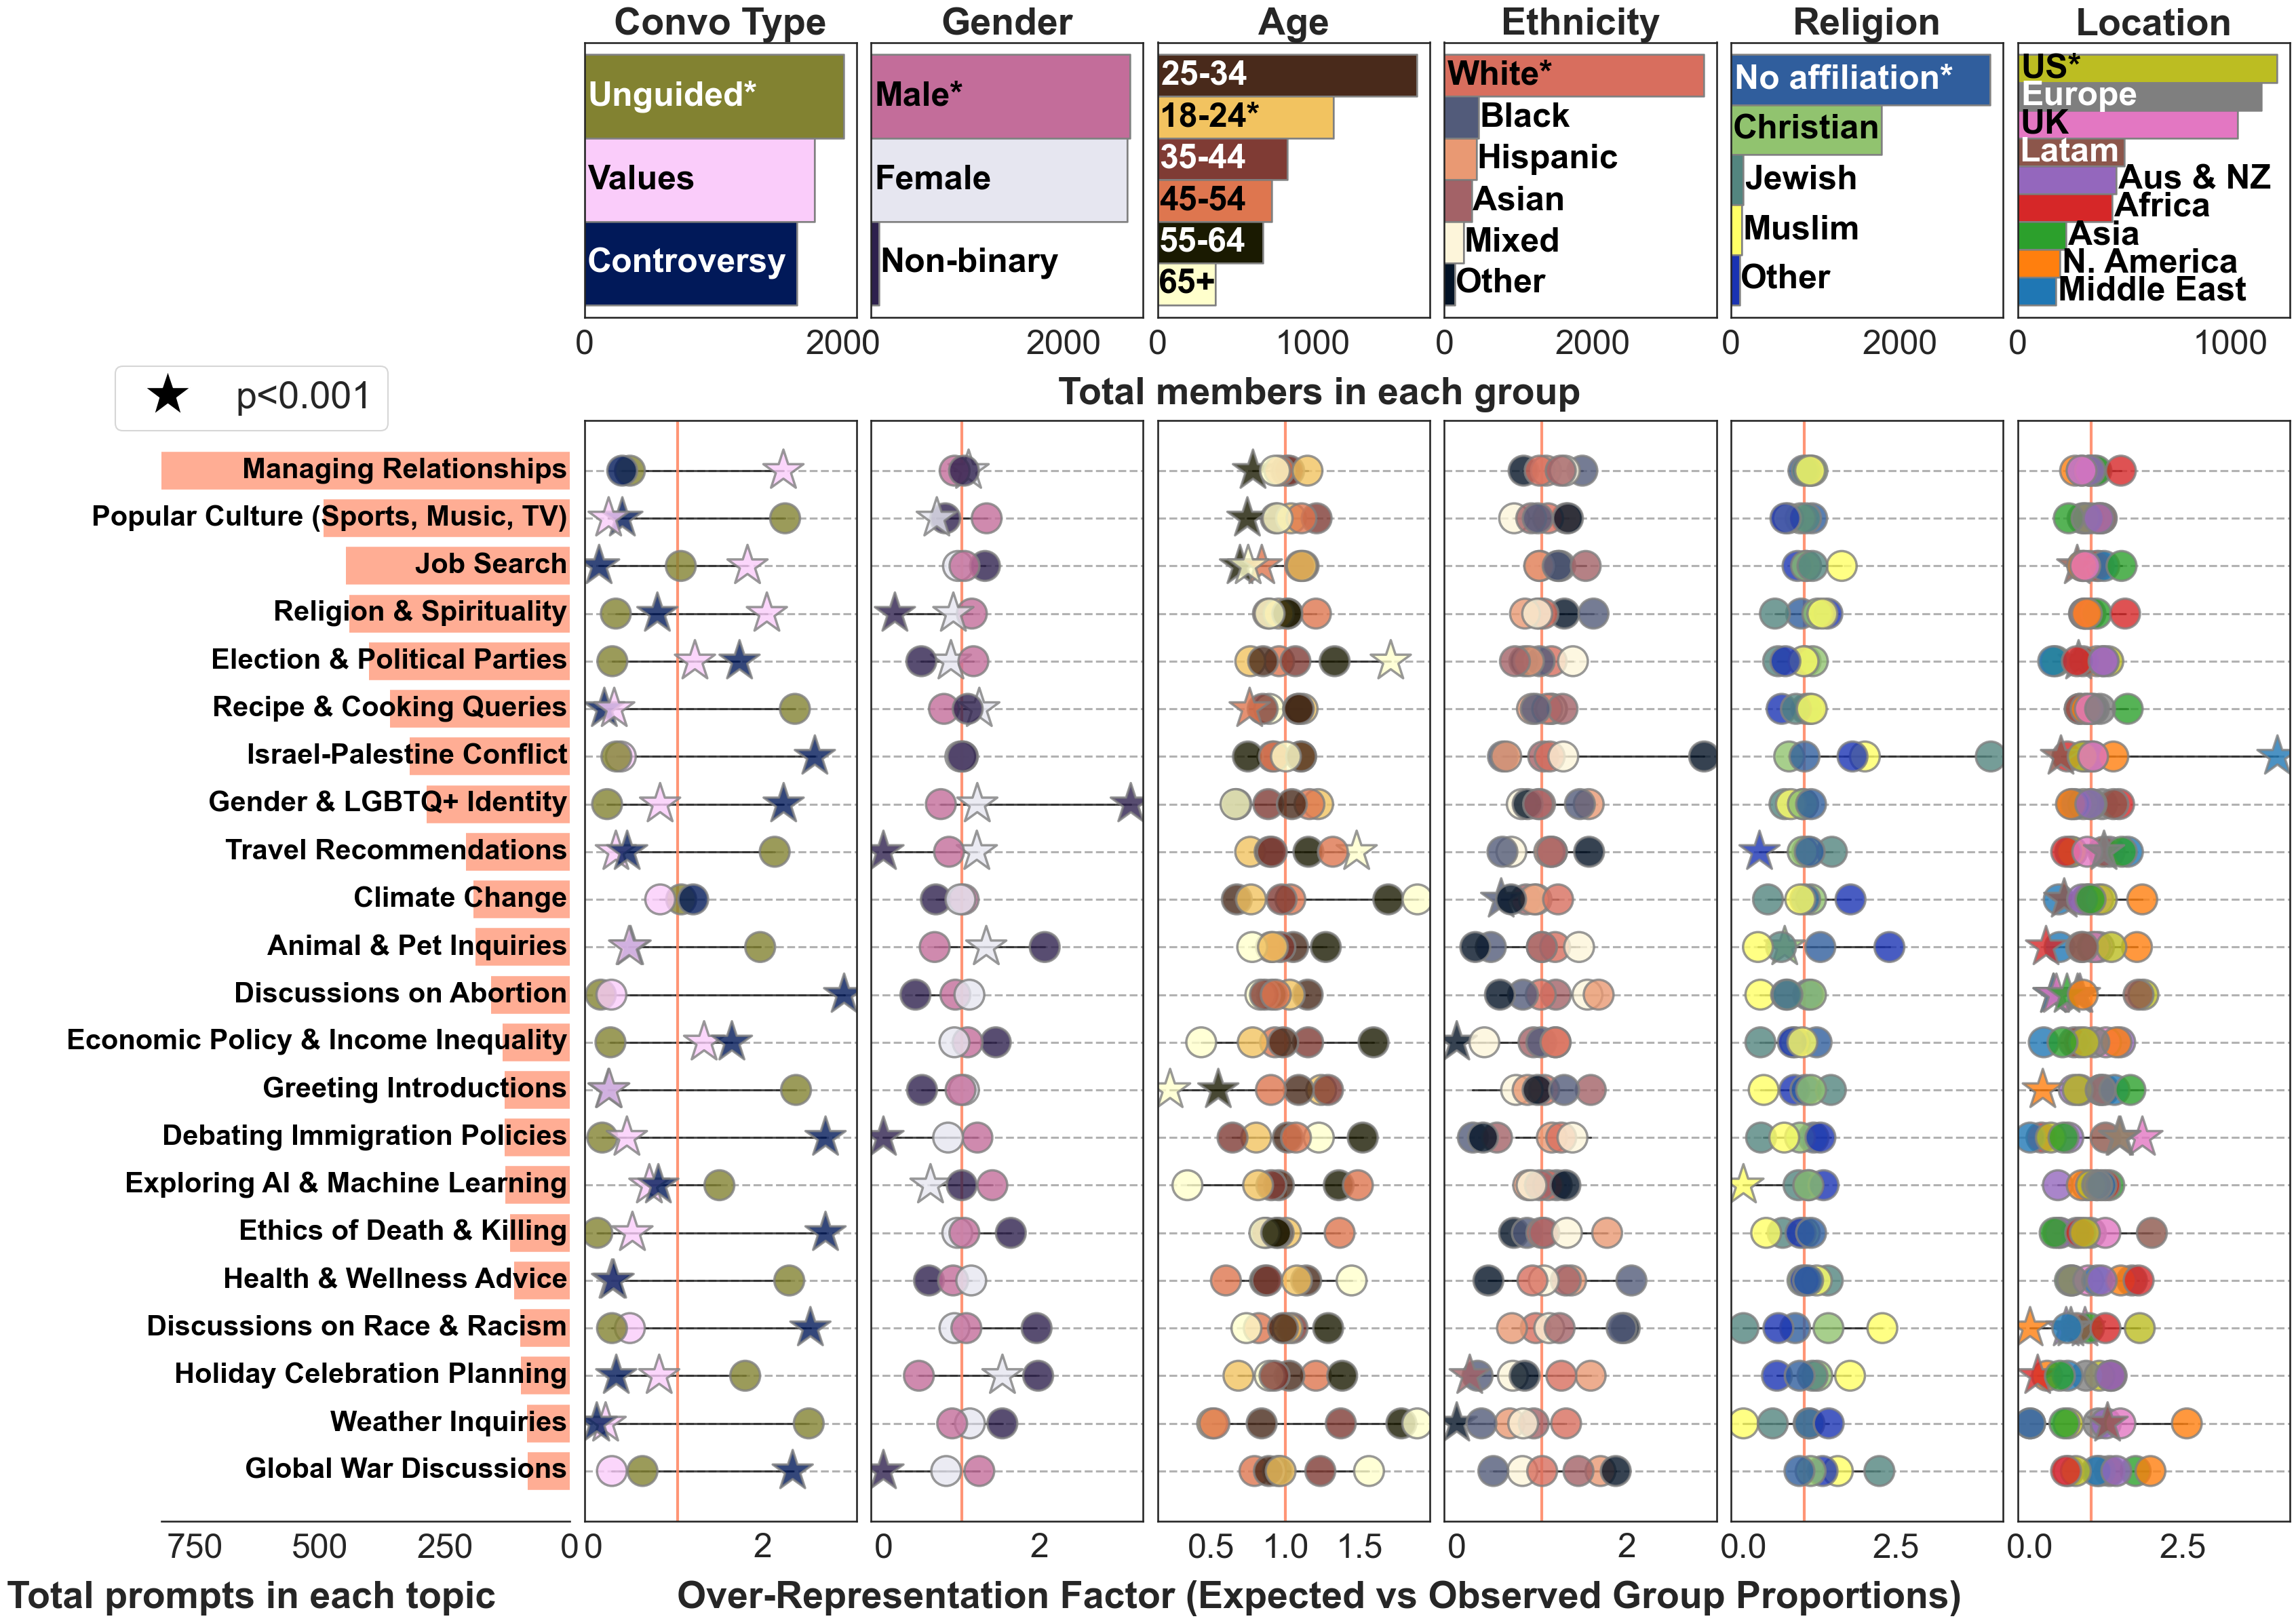

In [27]:
COLOR_STORE = {}
LABEL_STORE = {}

###############################
# SETUP
###############################
demo_cols = [
    "conversation_type",
    "gender",
    "age",
    "ethnicity_simplified",
    "religion_simplified",
    "location_special_region",
]

palettes = ["batlow", "acton", "lajolla", "lipari", "imola", "tab10"]
fig = plt.figure(figsize=(35, 23.5))
gs = GridSpec(
    1, len(demo_cols) + 1, width_ratios=[1.5, *([1] * len(demo_cols))], figure=fig
)
ticksize = 36
labelsize = 40
grp_bar_annot_size = 36
topic_bar_annot_size = 30
# X_COLUMN = "group_topic_proportion"
X_COLUMN = "overrepresentation_factor"


def assign_marker(row):
    topic_name = row["topic"]
    topic_id = name2id[topic_name]
    group = row["group"]
    if signif_data is not None:
        relevant_columns = [c for c in signif_data.columns if group in c]
        if len(relevant_columns) == 1:
            sig = signif_data.loc[topic_id, relevant_columns[0]]
            return "*" if sig == 1 else "o"  # Star for significant, circle otherwise
        else:
            return "o"
    else:
        return "o"


# The first panel is for topic sizes
y_bar = fig.add_subplot(gs[0, 0])

###############################
# Y BAR CHART
###############################
gs_y_bar = y_bar.get_subplotspec().subgridspec(2, 1, height_ratios=[1, 4])
bar_ax = fig.add_subplot(gs_y_bar[1])
empty_ax = fig.add_subplot(gs_y_bar[0])

# Plot the cluster sizes
bar_ax.barh(
    cluster_sizes["gpt_description"],
    cluster_sizes["count"],
    alpha=0.7,
    height=0.0,
    linewidth=40,
    edgecolor=basic_colors_dict["red"],
)

# Invert the x-axis to make the bars start on the right and go to the left
bar_ax.set_xlim(0, 816)
bar_ax.invert_xaxis()

# Turn off panel axis and ticks
y_bar.spines["bottom"].set_visible(False)
y_bar.spines["top"].set_visible(False)
y_bar.spines["left"].set_visible(False)
y_bar.spines["right"].set_visible(False)
y_bar.xaxis.set_ticks([])
y_bar.yaxis.set_ticks([])

# Now annotate the bar name on the bar
for t, topic in enumerate(cluster_sizes["gpt_description"]):
    topic_label = topic.replace("and", "&")
    bar_ax.text(
        5,
        t,
        topic_label,
        ha="right",
        va="center",
        color="black",
        fontsize=topic_bar_annot_size,
        fontweight="semibold",
    )

# # Now we can turn off the y-axis labels for the bar chart
bar_ax.set_yticks([])
bar_ax.set_ylabel("")
# Increase size of xticks
bar_ax.tick_params(axis="x", labelsize=ticksize)

# Turn off splines too
bar_ax.spines["top"].set_visible(False)
bar_ax.spines["left"].set_visible(False)
bar_ax.spines["right"].set_visible(False)

# And turn off empty ax
empty_ax.set_yticks([])
empty_ax.set_ylabel("")
empty_ax.set_xlabel("")
empty_ax.spines["bottom"].set_visible(False)
empty_ax.spines["top"].set_visible(False)
empty_ax.spines["left"].set_visible(False)
empty_ax.spines["right"].set_visible(False)
empty_ax.xaxis.set_ticks([])


###############################
# OTHER PANELS
###############################
panels = []
for i in range(len(demo_cols)):
    panel = fig.add_subplot(gs[0, i + 1])
    panels.append(panel)
    ###############################
    # SET UP DEMOGRAPHIC GROUPS
    ###############################
    demo_attr = demo_cols[i]
    data = data_store[demo_attr]
    try:
        signif_data = demo_signif_data[demo_attr]
        ref_group = reference_groups[demo_attr]
    except:
        signif_data = None
        ref_group = None

    # Create a nested subplot structure within each panel
    gs_panels = panel.get_subplotspec().subgridspec(2, 1, height_ratios=[1, 4])
    bar_ax = fig.add_subplot(gs_panels[0])
    scatter_ax = fig.add_subplot(gs_panels[1])
    short_title = demo_attr.split("_")[0].capitalize()
    if short_title == "Conversation":
        short_title = "Convo Type"
    panel.set_title(short_title, fontweight="semibold", fontsize=40)
    palette = palettes[i]
    data = data.sort_values(by="group_size", ascending=True)
    groups = data["group"].unique()
    colors = colorlist_dict[palette][0 : len(groups)]
    group_colors = {group: tuple(color) for group, color in zip(groups, colors)}

    COLOR_STORE[demo_attr] = group_colors

    # Sort by group size
    data = data.sort_values(by="group_size", ascending=True)

    ###############################
    # BAR CHART
    ###############################
    for g, group in enumerate(groups):
        plot_data = data[data["group"] == group]
        bar_height = 1
        bar_ax.barh(
            plot_data["group"],
            plot_data["group_size"],
            color=group_colors[group],
            label=group,
            height=bar_height,
            edgecolor="grey",
        )

    # For bars, put the group name inside the bar
    group_label_store = {}
    for g, group in enumerate(groups):
        bar_color = group_colors[group]
        is_dark = is_dark_color(bar_color)
        text_color = "white" if is_dark else "black"
        group_size = data[data["group"] == group]["group_size"].max()
        group_label = f"{group}*" if group == ref_group else group
        if demo_attr in ["ethnicity_simplified", "location_special_region"]:
            thresh = 500
        else:
            thresh = 150

        if demo_attr == "location_special_region":
            if group_label == "Latin America and the Caribbean":
                clean_group_label = "Latam"
            elif group_label == "Northern America":
                clean_group_label = "N. America"
            elif group_label == "Australia and New Zealand":
                clean_group_label = "Aus and NZ"
            else:
                clean_group_label = group_label
            clean_group_label = clean_group_label.replace(" and ", " & ")
        else:
            clean_group_label = group_label.capitalize()
        group_label_store[group_label] = clean_group_label
        # Put long bar labels inside bar
        if group_size > thresh:
            bar_ax.text(
                group_size / 80,
                g,
                clean_group_label,
                ha="left",
                va="center",
                color=text_color,
                fontsize=grp_bar_annot_size,
                fontweight="semibold",
            )
        # Put short bar labels outside bar
        else:
            bar_ax.text(
                group_size + 10,
                g,
                clean_group_label,
                ha="left",
                va="center",
                color="black",
                fontsize=grp_bar_annot_size,
                fontweight="semibold",
            )

    LABEL_STORE[demo_attr] = group_label_store

    # Now remove the y-axis labels for BAR
    bar_ax.set_yticks([])
    bar_ax.set_xlabel("")
    # Increase size of xticks
    bar_ax.tick_params(axis="x", labelsize=ticksize)

    ###############################
    # SCATTER CHART
    ###############################
    # Sort data topics in same order as the cluster_sizes dataframe
    data["topic_size"] = data["topic"].map(
        cluster_sizes.set_index("gpt_description")["count"]
    )
    data = data.sort_values(by="topic_size", ascending=True)
    assert len(data["topic"].unique()) == total_topics

    # # Create scaled size for scatter plot
    min_size = 1000
    max_size = 2000

    # Create a numeric index to plot topics on y
    data["order_id"] = data["topic"].map(
        {topic: j for j, topic in enumerate(cluster_sizes["gpt_description"])}
    )

    # Add color col
    data["color"] = data["group"].map(group_colors)

    # Add significance column
    data["marker"] = data.apply(assign_marker, axis=1)
    data["size"] = data["marker"].map(lambda x: 2000 if x == "*" else 1000)

    # Now scatter
    sns.scatterplot(
        x=X_COLUMN,
        y="order_id",
        hue="group",
        style="marker",
        size="size",
        sizes=(min_size, max_size),
        data=data,
        palette=group_colors,
        ax=scatter_ax,
        alpha=0.8,
        edgecolor="grey",
        legend=True,
        markers={"*": "*", "o": "o"},
    )

    # Get labels for legend
    if i == 1:
        handles, labels = scatter_ax.get_legend_handles_labels()
        scatter_ax.get_legend().remove()
    else:
        scatter_ax.get_legend().remove()

    # Add a dumbell between the min and max scatter
    for topic in data["topic"].unique():
        min_proportion = data[data["topic"] == topic][X_COLUMN].min()
        max_proportion = data[data["topic"] == topic][X_COLUMN].max()
        scatter_ax.plot(
            [min_proportion, max_proportion],
            [topic, topic],
            color="black",
            alpha=0.7,
            linestyle="-",
            zorder=0,
        )

    # Draw y-line for each topic on scatter
    for t, topic in enumerate(data["topic"].unique()):
        scatter_ax.axhline(
            y=t,
            color="black",
            alpha=0.3,
            linestyle="--",
            zorder=0,
        )

    # Remove axis ticks and labels (these are on the Y BAR)
    scatter_ax.set_yticks([])
    scatter_ax.set_ylabel("")
    scatter_ax.set_xlabel("")
    # Increase size of xticks
    scatter_ax.tick_params(axis="x", labelsize=ticksize)

    # Add vline at 1 (where expected proportion = observed proportion)
    scatter_ax.axvline(
        x=1,
        color=basic_colors_dict["red"],
        alpha=0.9,
        linestyle="-",
        linewidth=3,
        zorder=0,
    )

    # Turn off panel axis and ticks
    panel.spines["bottom"].set_visible(False)
    panel.spines["top"].set_visible(False)
    panel.spines["left"].set_visible(False)
    panel.spines["right"].set_visible(False)
    panel.xaxis.set_ticks([])
    panel.yaxis.set_ticks([])


# Custom legend
custom_handle = [
    Line2D([0], [0], marker="*", color="w", markerfacecolor="k", markersize=50)
]
fig.legend(
    custom_handle,
    ["p<0.001"],
    loc="upper center",
    bbox_to_anchor=(0.125, 0.775),
    fontsize=labelsize,
)

# Reduce space between subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.15)
# # Annotate subpanels
plt.text(
    0.575,
    -0.01,
    "Over-Representation Factor (Expected vs Observed Group Proportions)",  #
    fontsize=labelsize,
    fontweight="semibold",
    transform=fig.transFigure,
    ha="center",
    va="center",
)

plt.text(
    0.125,
    -0.01,
    "Total prompts in each topic",
    fontsize=labelsize,
    fontweight="semibold",
    transform=fig.transFigure,
    ha="center",
    va="center",
)

# Annotate subpanels
plt.text(
    0.575,
    0.745,
    "Total members in each group",
    fontsize=labelsize,
    fontweight="semibold",
    transform=fig.transFigure,
    ha="center",
    va="center",
)

plt.show()


# Save
fig.savefig(f"{PLOT_PATH}/bubble_topic.pdf", format="pdf", bbox_inches="tight")

## Topic Summary Table

In [28]:
order = [
    "cluster_id",
    "gpt_description",
    "cluster_size",
    "cluster_pct",
    "top_words",
    "top_texts",
]

summary_df = cluster_df[order].copy()
for col in ["top_words", "top_texts"]:
    summary_df[col] = summary_df[col].map(lambda x: ast.literal_eval(x))
    summary_df[f"{col}_len"] = summary_df[col].map(len)
display(summary_df.head())

cluster_id                      gpt_description  cluster_size  cluster_pct  \
0          -1                             Outliers          2578     0.321808   
1          19               Managing Relationships           816     0.101860   
2          14  Popular Culture (Sports, Music, TV)           493     0.061540   
3          18                           Job Search           448     0.055923   
4           6            Religion and Spirituality           441     0.055049   

                                           top_words  \
0  [think, people, hello, tell, like, hi, life, d...   
1  [family, relationship, important, think, value...   
2  [game, best, football, music, games, movie, vi...   
3  [work, job, money, make, time, working, home, ...   
4  [religion, god, believe, believe god, think, r...   

                                           top_texts  top_words_len  \
0  [Hello, How do I become financially stable on ...             10   
1  [What advice would you give for a man betrayed...             10   
2  [How many people love Star Trek?, I enjoy watc...             10   
3  [why is life hard to earn a good wage times ar...             10   
4  [What is the difference between being religiou...             10   

   top_texts_len  
0              5  
1              5  
2              5  
3              5  
4              5

In [29]:
# For each cluster find closest and furthest prompt to centroid
closest_texts = []
furthest_texts = []
furthest_5_texts = []
for cluster_id in summary_df["cluster_id"].unique():
    # Group by the cluster
    cluster = df[df["cluster_id"] == cluster_id].sort_values(by="distance_to_centroid")
    # Closest prompt
    closest = cluster["text"].iloc[0]
    closest_texts.append(closest)
    # Furthest prompt
    furthest = cluster["text"].iloc[-1]
    furthest_texts.append(furthest)
    # Get 5 furthest prompts
    furthest_5 = cluster["text"].iloc[-5:].to_list()
    # Reverse order
    furthest_5 = furthest_5[::-1]
    assert len(furthest_5) == 5
    furthest_5_texts.append(furthest_5)

summary_df["furthest_5_texts"] = furthest_5_texts
summary_df["closest_text"] = closest_texts
summary_df["furthest_text"] = furthest_texts

display(summary_df.head(2))

cluster_id         gpt_description  cluster_size  cluster_pct  \
0          -1                Outliers          2578     0.321808   
1          19  Managing Relationships           816     0.101860   

                                           top_words  \
0  [think, people, hello, tell, like, hi, life, d...   
1  [family, relationship, important, think, value...   

                                           top_texts  top_words_len  \
0  [Hello, How do I become financially stable on ...             10   
1  [What advice would you give for a man betrayed...             10   

   top_texts_len                                   furthest_5_texts  \
0              5  [What do you think about China's implementatio...   
1              5  [How can we make the world a better place for ...   

                                        closest_text  \
0                                              Hello   
1  What advice would you give for a man betrayed ...   

                                       furthest_text  
0  What do you think about China's implementation...  
1  How can we make the world a better place for e...

In [30]:
# Column setup
keep_cols = [
    "gpt_description",
    "cluster_size",
    "cluster_pct",
    "top_words",
    "top_texts",
    "furthest_5_texts",
]
clean_names = [
    "Topic Name",
    "Size",
    "Pct",
    "Top Words",
    "Closest Texts",
    "Furthest Texts",
]

In [31]:
# Manipualte for latex output
output_df = summary_df[keep_cols].copy()
output_df.columns = clean_names

output_df.head()
output_df["Pct"] = output_df["Pct"].apply(
    lambda x: f"\\smallpcb{{{x*100:.1f}}}\\%" if not pd.isna(x) else np.nan
)

list_cols = ["Top Words", "Closest Texts", "Furthest Texts"]
# Make into a string with rank
for col in list_cols:
    output_df[col] = output_df[col].map(
        lambda x: ", ".join([f"{i}{col[0]}START``{y}''XXEND" for i, y in enumerate(x)])
    )

In [32]:
styled_df = output_df.style
styled_df = styled_df.format(escape="latex", subset=list_cols)

# Hide index
styled_df = styled_df.hide(axis="index")

# Make Topic Name column bold
styled_df.set_properties(subset=["Topic Name"], **{"font-weight": "bold"})

# Get some blue colors
blue_colors = sns.color_palette("Blues", 20)
# Reverse list and only take 10
blue_colors = blue_colors[::-1][:10]

# Get some green colors
green_colors = sns.color_palette("Greens", 15)
green_colors = green_colors[::-1][:5]

# Get some red colors
red_colors = sns.color_palette("Reds", 15)
red_colors = red_colors[::-1][:5]

# Initialize a string to hold color definitions
color_definitions = ""

# Convert to LaTeX
latex_str = "\\fontsize{6pt}{6pt}\\selectfont\n" + styled_df.to_latex(
    hrules=True,
    convert_css=True,
    environment="longtable",
    caption="ADD CAPTION HERE",
    label="tab:ADD_LABEL_HERE",
)

# Add a line between each row
latex_str = latex_str.replace("\\bfseries", "\\midrule \\bfseries")

# Replace col alignments
latex_str = latex_str.replace(
    "{lrllll}",
    "{p{0.15\\textwidth}p{0.05\\textwidth}lp{0.15\\textwidth}p{0.2\\textwidth}p{0.2\\textwidth}}",
)

for i, color in enumerate(blue_colors):
    # Define each color
    color_name = f"bluecolor{i}"
    color_definitions += f"\\definecolor{{{color_name}}}{{rgb}}{{{color[0]:.2f}, {color[1]:.2f}, {color[2]:.2f}}}\n"

    # Replace placeholders with the defined color names
    latex_str = latex_str.replace(
        f"{i}TSTART", f"\\textcolor{{{color_name}}}{{"
    ).replace("XXEND", "}")

for i, color in enumerate(green_colors):
    # Define each color
    color_name = f"greencolor{i}"
    color_definitions += f"\\definecolor{{{color_name}}}{{rgb}}{{{color[0]:.2f}, {color[1]:.2f}, {color[2]:.2f}}}\n"

    # Replace placeholders with the defined color names
    latex_str = latex_str.replace(f"{i}CSTART", f"\\textcolor{{{color_name}}}{{")

for i, color in enumerate(red_colors):
    # Define each color
    color_name = f"redcolor{i}"
    color_definitions += f"\\definecolor{{{color_name}}}{{rgb}}{{{color[0]:.2f}, {color[1]:.2f}, {color[2]:.2f}}}\n"

    # Replace placeholders with the defined color names
    latex_str = latex_str.replace(f"{i}FSTART", f"\\textcolor{{{color_name}}}{{")

print(color_definitions + latex_str)

\definecolor{bluecolor0}{rgb}{0.03, 0.24, 0.49}
\definecolor{bluecolor1}{rgb}{0.03, 0.29, 0.56}
\definecolor{bluecolor2}{rgb}{0.04, 0.33, 0.62}
\definecolor{bluecolor3}{rgb}{0.08, 0.38, 0.66}
\definecolor{bluecolor4}{rgb}{0.12, 0.43, 0.70}
\definecolor{bluecolor5}{rgb}{0.17, 0.48, 0.73}
\definecolor{bluecolor6}{rgb}{0.22, 0.53, 0.75}
\definecolor{bluecolor7}{rgb}{0.27, 0.58, 0.78}
\definecolor{bluecolor8}{rgb}{0.33, 0.62, 0.80}
\definecolor{bluecolor9}{rgb}{0.39, 0.66, 0.83}
\definecolor{greencolor0}{rgb}{0.00, 0.34, 0.14}
\definecolor{greencolor1}{rgb}{0.00, 0.42, 0.17}
\definecolor{greencolor2}{rgb}{0.07, 0.48, 0.22}
\definecolor{greencolor3}{rgb}{0.13, 0.54, 0.27}
\definecolor{greencolor4}{rgb}{0.19, 0.61, 0.32}
\definecolor{redcolor0}{rgb}{0.52, 0.03, 0.07}
\definecolor{redcolor1}{rgb}{0.64, 0.06, 0.08}
\definecolor{redcolor2}{rgb}{0.72, 0.08, 0.10}
\definecolor{redcolor3}{rgb}{0.79, 0.09, 0.11}
\definecolor{redcolor4}{rgb}{0.86, 0.16, 0.14}
\fontsize{6pt}{6pt}\selectfont
\begin{lo

## Interaction of Score and Topic

Originally 1396 people
Now 1374 binary gender people
Prop of utterance ratings by gender:
gender
Male      0.509025
Female    0.490975
Name: proportion, dtype: float64


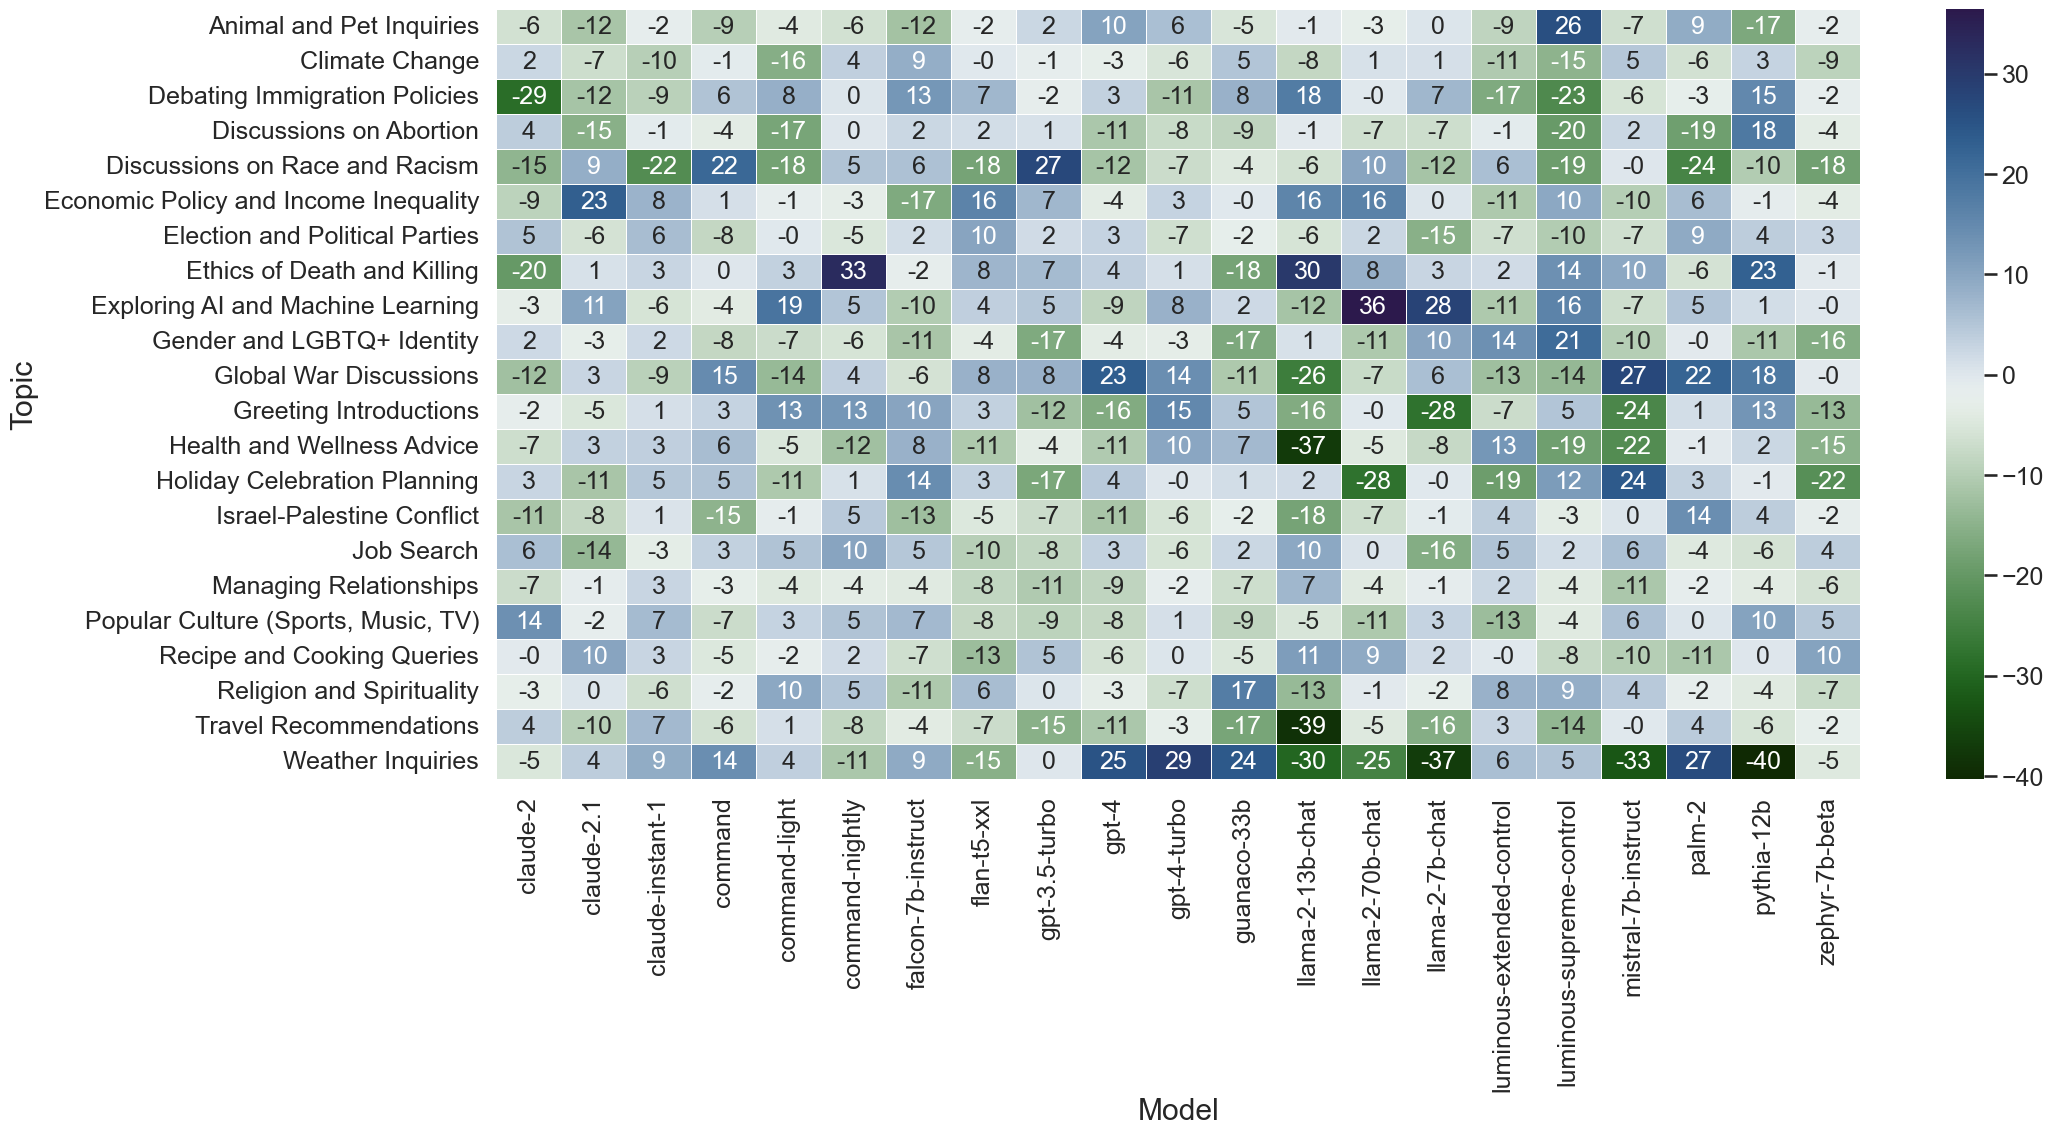

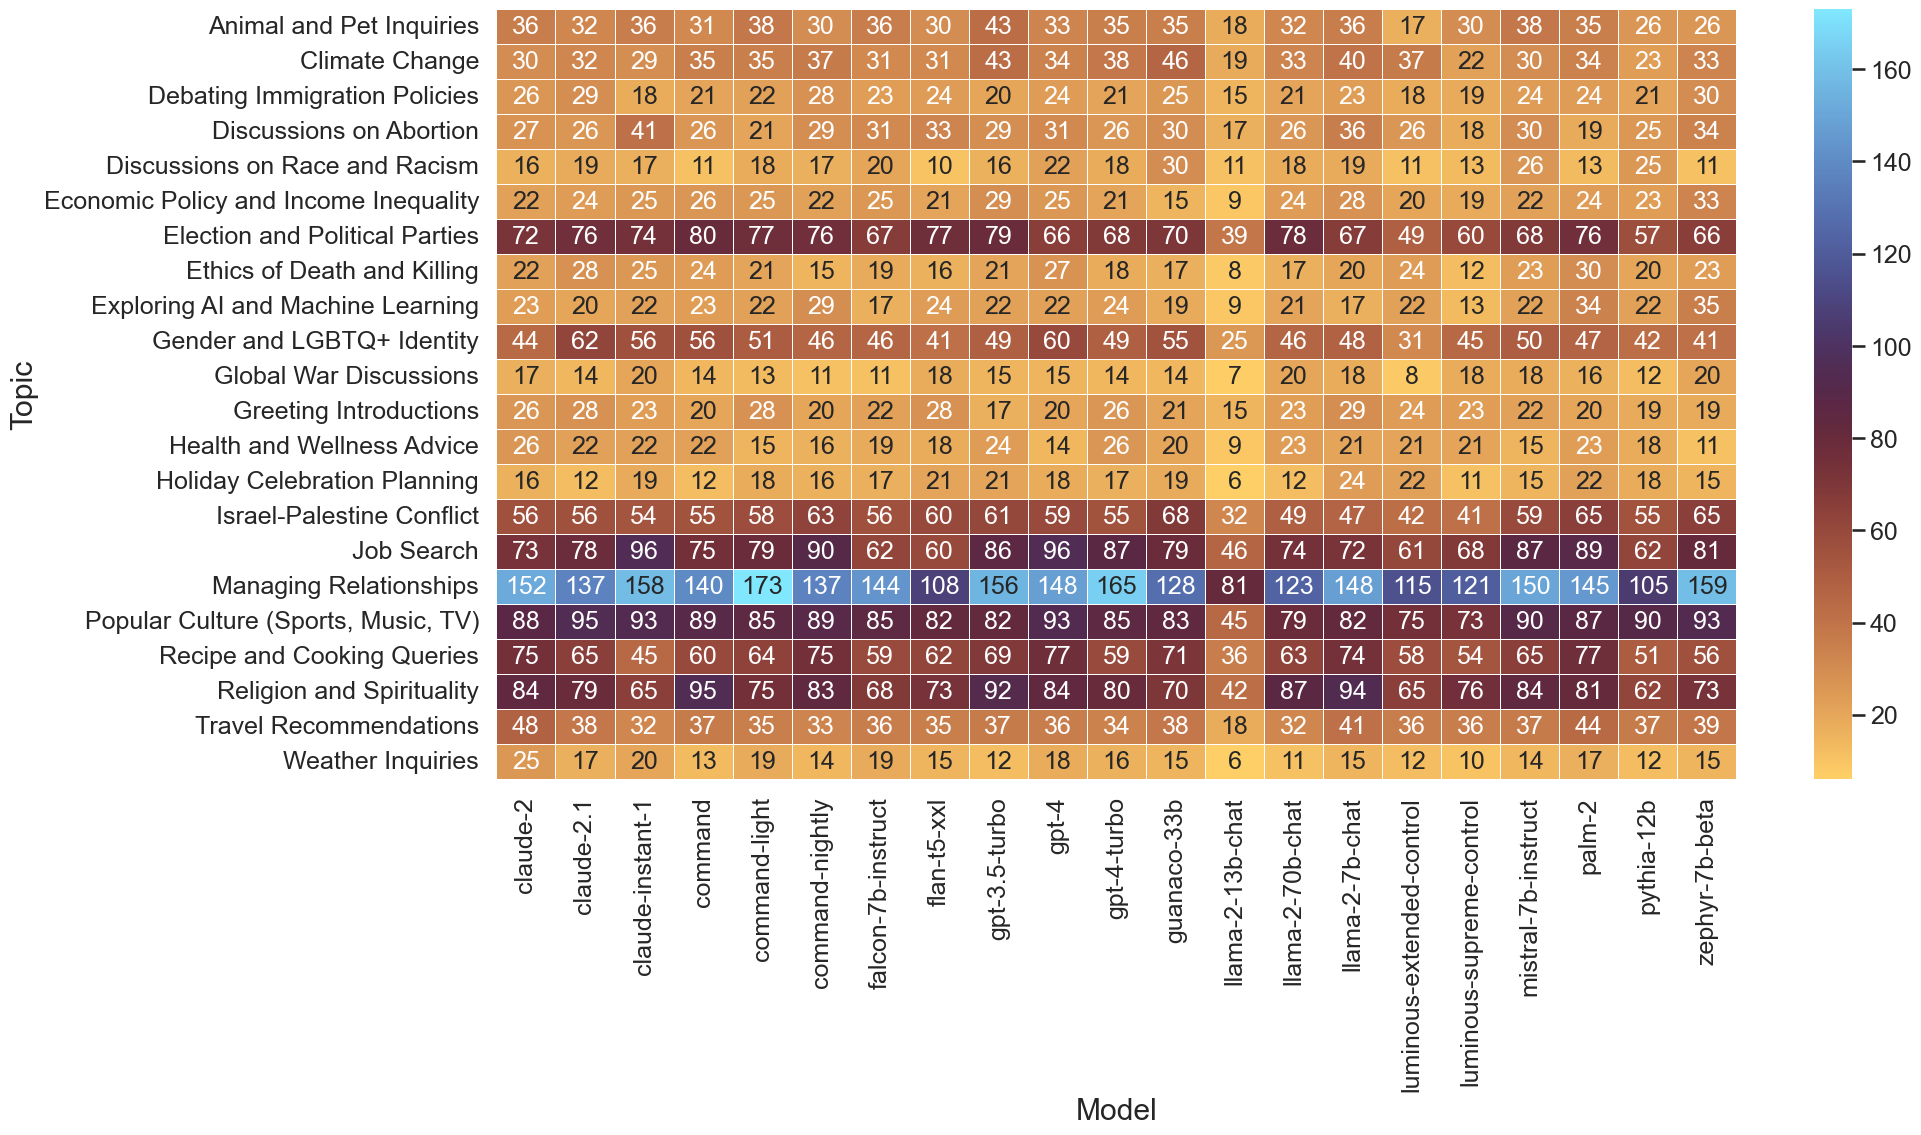

In [33]:
# Create a merged version of the data
merged = data_dict['utterances'].merge(data_dict['survey'], on="user_id", how="left")
merged = merged[(merged['turn'] == 0)]
merged = merged.merge(df_no_outliers[['conversation_id', 'gpt_description', 'cluster_id']], on = 'conversation_id', how = 'left')
models = merged['model_name'].unique().tolist()
# Only keep binary gender because biggest demographic divider
print(f'Originally {merged['user_id'].nunique()} people')
merged = merged[merged['gender'].isin(['Male', 'Female'])]
print(f'Now {merged['user_id'].nunique()} binary gender people')
print('Prop of utterance ratings by gender:')
print(merged['gender'].value_counts(normalize=True))

def diff_in_means_gender(x):
    group1 = x[x['gender'] == 'Male']['score'].mean()
    group2 = x[x['gender'] == 'Female']['score'].mean()
    return group1 - group2

# Find the difference in means for each model and topic
average_scores = merged.groupby(['model_name', 'gpt_description']).apply(diff_in_means_gender, include_groups=False).reset_index(name='difference')

# Get counts of people in each cross tab
counts = merged.groupby(['model_name', 'gpt_description'])['user_id'].nunique().reset_index(name='user_count')

# Pivot the table to display models on the x-axis and clusters on the y-axis
pivot_table = average_scores.pivot(index='gpt_description', columns='model_name', values='difference')
pivot_counts = counts.pivot(index='gpt_description', columns='model_name', values='user_count')


# Make the score diff heatmap
plt.figure(figsize=(22, 10))
sns.heatmap(pivot_table, cmap=palettes_dict['cork'].reversed(), annot=True, fmt=".0f", linewidths=.5)
plt.xlabel('Model')
plt.ylabel('Topic')
plt.savefig(f"{PLOT_PATH}/topic_model_heatmap_diffs.pdf", format="pdf", bbox_inches="tight")
plt.show()


# Make the count heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(pivot_counts, cmap=palettes_dict['managua'], annot=True, fmt=".0f", linewidths=.5)
plt.xlabel('Model')
plt.ylabel('Topic')
plt.savefig(f"{PLOT_PATH}/topic_model_heatmap_counts.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [34]:
# Double check these are unique users
merged["user_id"][
    (merged["gpt_description"] == "Job Search") & (merged["model_name"] == "claude-2")
].nunique()

73